In [67]:
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import random
import matplotlib.pyplot as plt

In [68]:
cd ..

/Users/oliviawatkins/Documents/Schoolwork/NN


In [69]:
from neural_nets_library import training

In [70]:
iteration = 0

In [71]:
def checkProb(vec, dim, name):
    # Get rid of batch dim
    sums = torch.sum(vec, dim)
    prob = torch.max(torch.abs(sums - 1)).data[0]
    if not prob < .002:
        print("BAD PROB", prob, name, vec)
    return prob < .002
    

In [72]:
class Controller(nn.Module):
    """
    Contains the two learnable parts of the model in four independent, fully connected layers.
    First the initial values for the registers and instruction registers and second the 
    parameters that computes the required distributions. 
    """

    def __init__(self, 
                 first_arg = None, 
                 second_arg = None, 
                 output = None, 
                 instruction = None, 
                 initial_registers = None, 
                 IR = None,
                 stop_threshold = 1, 
                 multiplier = 5,
                 correctness_weight = .2, 
                 halting_weight = .2, 
                 confidence_weight = .2, 
                 efficiency_weight = .4,
                 t_max = 75):
        """
        Initialize a bunch of constants and pass in matrices defining a program.
        
        :param first_arg: Matrix with the 1st register argument for each timestep stored in the columns (RxM)
        :param second_arg: Matrix with the 2nd register argument for each timestep stored in the columns (RxM)
        :param output: Matrix with the output register for each timestep stored in the columns (RxM)
        :param instruction: Matrix with the instruction for each timestep stored in the columns (NxM)
        :param initial_registers: Matrix where each row is a distribution over the value in one register (RxM)
        :param stop_threshold: The stop probability threshold at which the controller should stop running
        :param multiplier: The factor our one-hot vectors are be multiplied by before they're softmaxed to add blur
        :param correctness_weight: Weight given to the correctness component of the loss function
        :param halting_weight: Weight given to the halting component of the loss function
        :param confidence_weight: Weight given to the confidence component of the loss function
        :param efficiency_weight: Weight given to the efficiency component of the loss function
        
        """
        super(Controller, self).__init__()
        
        # Initialize dimension constants
        R, M = initial_registers.size()
        self.M = M
        self.R = R
        self.times = []
        
        # Initialize loss function weights
        # In the ANC paper, these scalars are called, alpha, beta, gamma, and delta
        self.correctness_weight = correctness_weight
        self.halting_weight = halting_weight
        self.confidence_weight = confidence_weight
        self.efficiency_weight = efficiency_weight
        
        # And yet more initialized constants... yeah, there are a bunch, I know.
        self.t_max = t_max
        self.stop_threshold = stop_threshold
        self.multiplier = multiplier

        # Initialize parameters.  These are the things that are going to be optimized. 
        self.first_arg = nn.Parameter(multiplier * first_arg)
        self.second_arg = nn.Parameter(multiplier * second_arg)
        self.output = nn.Parameter(multiplier * output)
        self.instruction = nn.Parameter(multiplier * instruction) 
        self.registers = nn.Parameter(multiplier * initial_registers)
#         self.first_arg = multiplier * first_arg
#         self.second_arg = multiplier * second_arg
#         self.output = multiplier * output
#         self.instruction = multiplier * instruction
#         self.registers = multiplier * initial_registers
        
        IR = torch.zeros(M)
        IR[0] = 1
        self.IR = nn.Parameter(multiplier * IR)
#         self.IR = multiplier * IR
                
        # Machine initialization
        self.machine = Machine(M, R)
        self.softmax = nn.Softmax(0)
    
    
    def forward(self, input, forward_train):
        if forward_train:
            print("FT!!!")
            return self.forward_train(input)
        else:
            print("FP!!!")
            return self.forward_predict(self, input)
        
    def forward_wrapper(self, input, output_mem, output_mask):
        return (self.forward_train(input, (output_mem, output_mask)),)
    
    def forward_train(self, input, output):
        """
        Runs the controller on a certain input memory matrix. It returns the loss.
        
        :param initial_memory: The state of memory at the beginning of the program.
        :param output_meory: The desired state of memory at the end of the program.
        :param output_mask: The parts of the output memory that are relevant.
        
        :return: Returns the training loss.
        """
    
        
        initial_memory = input
        output_memory = output[0]
        output_mask = output[1]
        # Program's initial memory #TODO: Variable?
        
        #TODO: Uncomment when gradcheck removed
        self.memory = Variable(initial_memory)
        self.output_memory = Variable(output_memory)
        self.output_mask = Variable(output_mask)
        
        self.stop_probability = Variable(torch.zeros(1))
        
        # Copy registers so we aren't using the values from the previous iteration. Also
        # make both registers and IR into a probability distribution.
        registers = nn.Softmax(1)(self.registers)
        IR = self.softmax(self.IR)
        
        # loss initialization
        self.confidence = 0
        self.efficiency =  1
        self.halting = 0
        self.correctness = 0
        
        t = 0 
        
#         print("///////////////////////START///////////////////////////")
                
        # Run the program, one timestep at a time, until the program terminates or whe time out
        while t < self.t_max and float(self.stop_probability) < self.stop_threshold: 
            
            a = self.softmax(torch.matmul(self.first_arg, IR))
            b = self.softmax(torch.matmul(self.second_arg, IR))
            o = self.softmax(torch.matmul(self.output, IR))
            e = self.softmax(torch.matmul(self.instruction, IR))
            
#             print("=====================INPUT==============")
#             print("Mem", type(self.memory))
#             print("Instruction Reg", type(IR))
#             print("Regs", type(registers))
#             print("arg 1", type(a))
#             print("arg 2", type(b))
#             print("target", type(o))
#             print("E (inst)", type(e))
#             print("stop", type(self.stop_probability))
                        
            # Update memory, registers, and IR after machine operation
            self.old_stop_probability = self.stop_probability
            self.memory, registers, IR, new_stop_prob = self.machine(e, a, b, o, self.memory, registers, IR)
            self.stop_probability = self.stop_probability + (new_stop_prob * (1 - self.stop_probability))
            self.timestep_loss(t)
            t += 1
        
        self.final_loss(t)
        self.times.append(t)
        return self.total_loss()
    
    def forward_prediction(self, input):
        """
        Runs the controller on a certain input memory matrix. It returns the output memory matrix.
        
        :param initial_memory: The state of memory at the beginning of the program.
        
        :return: Returns the output memory matrix.
        """
        memory = input[0]
        # Program's initial memory
        self.memory = Variable(memory)
        self.stop_probability = 0
        
        # Copy registers so we aren't using the values from the previous iteration. Also
        # make both registers and IR into a probability distribution.
        registers = nn.Softmax(1)(self.registers)
        IR = self.softmax(self.IR)
        
        t = 0 
        
        # Run the program, one timestep at a time, until the program terminates or whe time out
        while t < float(self.t_max) and float(self.stop_probability) < float(self.stop_threshold): 
            
            
            
            a = self.softmax(torch.matmul(self.first_arg, IR))
            b = self.softmax(torch.matmul(self.second_arg, IR))
            o = self.softmax(torch.matmul(self.output, IR))
            e = self.softmax(torch.matmul(self.instruction, IR))
                        
            # Update memory, registers, and IR after machine operation
            self.old_stop_probability = self.stop_probability
            self.memory, registers, IR, new_stop_prob = self.machine(e, a, b, o, self.memory, registers, IR) 
            
            self.stop_probability = self.stop_probability + new_stop_prob
            t += 1
        
        return self.memory, None
    
    def timestep_loss(self, t):
        # Confidence Loss 
        mem_diff = self.output_memory - self.memory
        correctness = torch.sum(self.output_mask * mem_diff * mem_diff)
#         print("conf probs", self.stop_probability - self.old_stop_probability)
        self.confidence = self.confidence + (self.stop_probability - self.old_stop_probability) * correctness
#         print("confidence loss - timestep")
#         print("correctness", float(correctness))
#         print('stop diff', float(self.stop_probability - self.old_stop_probability))
#         print("weight", self.confidence_weight)
#         print("update ", (self.stop_probability - self.old_stop_probability) * correctness * self.confidence_weight)
#         print("confidence:", float(self.confidence * self.confidence_weight))
        
        
        
        # Efficiency Loss
#         if float(self.stop_probability) < self.stop_threshold: # don't add efficiency loss if it stops
        self.efficiency = self.efficiency + (1 - self.stop_probability)
#         print("efficiency", float(self.stop_probability), float(self.efficiency * self.efficiency_weight))
               
    
    def final_loss(self, t):
        # Correctness loss
#         print("TTT", t)
        mem_diff = self.output_memory - self.memory
#         print("diff", self.output_mask * mem_diff * mem_diff)
        self.correctness = torch.sum(self.output_mask * mem_diff * mem_diff)

        # Halting loss
        if t == self.t_max:
            self.halting = (1 - self.stop_probability)

    def total_loss(self):
        """ compute four diferent loss functions and return a weighted average of the four measuring correctness, 
        halting, efficiency, and confidence"""
#         print("WWW", self.confidence_weight)
#         print("MEMORY", self.memory)
#         print("confidence", float(self.confidence * self.confidence_weight))
#         print("efficiency", float(self.efficiency * self.efficiency_weight))
#         print("halting", float(self.halting * self.halting_weight))
#         print("correctness", float(self.correctness * self.correctness_weight))
#         print("weight sum", (self.correctness*self.correctness_weight) + (self.confidence_weight*self.confidence) + (self.halting_weight*self.halting) + (self.efficiency_weight*self.efficiency))
        
        return  (self.correctness*self.correctness_weight) + (self.confidence_weight*self.confidence) + (self.halting_weight*self.halting) + (self.efficiency_weight*self.efficiency)     

In [73]:
class Operation(nn.Module):
    """
    Parent class for our binary operations
    """
    def __init__(self, M):
        """
        Initialize the memory length (needed so we can mod our answer in case it exceeds the range 0-M-1)
        Also calculate the output matrix for the operation
        
        :param M: Memory length
        """
        super(Operation, self).__init__()
        self.M = M
        
        # Create a MxMxM matrix where the (i,j,k) cell is 1 iff operation(i,j) = k.
        self.outputs = torch.IntTensor(M, M, M).zero_()
        for i in range(M):
            for j in range(M):
                val = self.compute(i, j)
                self.outputs[i][j][val] = 1
                
        self.outputs = Variable(self.outputs)
    
    def compute(self, x, y):
        """ 
        Perform the binary operation.  The arguments may or may not be used.
        
        :param x: First argument
        :param y: Second argument
        """
        raise NotImplementedError
    
    def forward(self):
        """
        :return: The output matrix
        """
        return self.outputs

In [74]:
class Add(Operation):

    def __init__(self, M):
        super(Add, self).__init__(M)
    
    def compute(self, x, y):
        return (x + y) % self.M


In [75]:
class Stop(Operation):
    
    def __init__(self, M):
        super(Stop, self).__init__(M)

    def compute(self, _1, _2):
        return 0

In [76]:
class Jump(Operation):
    
    def __init__(self, M):
        super(Jump, self).__init__(M)

    def compute(self, _1, _2):
        return 0 # Actual jump happens in the Machine class

In [77]:
class Decrement(Operation):
    
    def __init__(self, M):
        super(Decrement, self).__init__(M)

    def compute(self, x, _):
        return (x - 1) % self.M

In [78]:
class Increment(Operation):
    
    def __init__(self, M):
        super(Increment, self).__init__(M)

    def compute(self, x, _):
        return (x + 1) % self.M

In [79]:
class Max(Operation):
    
    def __init__(self, M):
        super(Max, self).__init__(M)

    def compute(self, x, y):
        return max(x,y)

In [80]:
class Min(Operation):
    
    def __init__(self, M):
        super(Min, self).__init__(M)

    def compute(self, x, y):
        return min(x,y)

In [81]:
class Read(Operation):
    
    def __init__(self, M):
        super(Read, self).__init__(M)
        # Leave output matrix blank since we're gonna do the reading elsewhere
        self.outputs = torch.zeros(M, M, M)

    def compute(self, x, _):
        return 0 # Actual reading happens in the Machine class

In [82]:
class Subtract(Operation):
    
    def __init__(self, M):
        super(Subtract, self).__init__(M)

    def compute(self, x, y):
        return (x - y) % self.M

In [83]:
class Write(Operation):
    
    def __init__(self, M):
        super(Write, self).__init__(M)

    def compute(self, x, y):
        return 0 # Actual write happens in the Machine class

In [84]:
class Zero(Operation):
    
    def __init__(self, M):
        super(Zero, self).__init__(M)

    def compute(self, _1, _2):
        return 0

In [85]:
class Machine(nn.Module):
    """
    The Machine executes assembly instructions passed to it by the Controller.
    It updates the given memory, registers, and instruction pointer.
    The Machine doesn't have any learnable parameters.
    """
    def __init__(self, M, R):
        """
        Initializes dimensions, operations, and counters
        
        :param M: Memory length.  Integer values also take on values 0-M-1.  M is also the program length.
        :param R: Number of registers
        """
        super(Machine, self).__init__()
        
        # Store parameters as class variables
        self.R = R # Number of registers
        self.M = M # Memory length (also largest number)
        
        # Start off with 0 probability of stopping
        self.stop_probability = 0 
        
        # List of ops (must be in same order as the original ANC paper so compilation works right)
        self.ops = [ 
            Stop(M),
            Zero(M),
            Increment(M),
            Add(M),
            Subtract(M),
            Decrement(M),
            Min(M),
            Max(M),
            Read(M),
            Write(M),
            Jump(M)
        ]
        
        # Number of instructions
        self.N = len(self.ops)
        
        # Create a 4D matrix composed of the output matrices of each of the ops
        self.outputs = Variable(torch.zeros(self.N, self.M, self.M, self.M))
        
        for i in range(self.N):
            op = self.ops[i]
            self.outputs[i] = op()
                
        # Keep track of ops which will be handled specially
        self.jump_index = 10
        self.stop_index = 0
        self.write_index = 9
        self.read_index = 8 
        
    def forward(self, e, a, b, o, memory, registers, IR):
        
        """
        Run the Machine for one timestep (corresponding to the execution of one line of Assembly).
        The first four parameter names correspond to the vector names used in the original ANC paper
        
        :param e: Probability distribution over the instruction being executed (N)
        :param a: Probability distribution over the first argument register (length R)
        :param b: Probability distribution over the second argument register (length R)
        :param o: Probability distribution over the first argument register (length R)
        :param memory: Memory matrix (size MxM)
        :param registers: Register matrix (size RxM)
        :param IR: Instruction Register (length M)
        
        :return: The memory, registers, and instruction register after the timestep
        """
        
        # Calculate distributions over the two argument values by multiplying each 
        # register by the probability that register is being used.
        arg1 = torch.matmul(a, registers)
        arg2 = torch.matmul(b, registers)
        
        # Multiply the output matrix by the arg1, arg2, and e vectors. Also take care
        # of doing the read.
        
        arg1_long = arg1.view(1, -1, 1, 1)
        arg2_long = arg2.view(1, 1, -1, 1)
        instr = e.view(-1, 1, 1, 1)
        read_vec =  e[self.read_index] * torch.matmul(arg1, memory)
        out_vec = (self.outputs * arg1_long * arg2_long * instr).sum(0).sum(0).sum(0) + read_vec      
        out_vec = out_vec.squeeze(0)

        # Update our memory, registers, instruction register, and stopping probability
        memory = self.writeMemory(e, memory, arg1, arg2)
        registers = self.writeRegisters(out_vec, o, registers)
        IR = self.updateIR(e, IR, arg1, arg2)
        stop_prob = self.getStop(e)
        
        return(memory, registers, IR, stop_prob)
             
    def writeRegisters(self, out, o, registers):
        """
        Write the result of our operation to our registers.
        
        :param out: Probability distribution over the output value (M)
        :param o: Probability distribution over the output register (R)
        :param Registers: register matrix (RxM)
        
        :return: The updated registers (RxM)
        """
        # Multiply probability of not writing with old registers and use an outer product
        return (1 - o).unsqueeze(1) * registers + torch.ger(o, out)
    
    def updateIR(self, e, IR, arg1, arg2):
        """
        Update the instruction register
        
        :param e: Distribution over the current instruction (N)
        :param IR: Instruction register (length M)
        :param arg1: Distribution over the first argument value (length M)
        :param arg2: Distribution over the second argument value (length M)
        
        :return: The updated instruction register (BxMx1)
        """
        # probability of actually jumping
        cond = e[self.jump_index] * arg1[0]
        
        # Take a weighted sum of the instruction register with and without jumping
        return torch.cat([IR[-1], IR[:-1]], 0) * (1 - cond) + arg2 * cond
    
    def writeMemory(self, e, mem_orig, arg1, arg2):
        """
        Update the memory
        
        :param e: Distribution over the current instruction (M)
        :param mem_orig: Current memory matrix (MxM)
        :param arg1: Distribution over the first argument value (M)
        :param arg2: Distribution over the second argument value (M)
        
        :return: The updated memory matrix (MxM)
        """
        
        # Probability that we're on the write instruction
        write_probability = e[self.write_index]
        mem_write = torch.ger(arg1, arg2) 
        mem_write = mem_write + (1 - arg1).unsqueeze(1) * mem_orig
        
        return mem_orig * (1 - write_probability) + write_probability * mem_write

    def getStop(self, e):
        """
        Obtain the probability that we will stop at this timestep based on the probability that we are running the STOP op.
        
        :param e: distribution over the current instruction (length M)
        
        :return: probability representing whether the controller should stop.
        """
#         print("Stop coef", e[self.stop_index])
        return e[self.stop_index]

In [86]:
def one_hotify(vec, number_of_classes, dimension):
    """
    Turn a tensor of integers into a matrix of one-hot vectors.
    
    :param vec: The vector to be converted.
    :param number_of_classes: How many possible classes the one hot vectors encode.
    :param dimension: Which dimension stores the elements of vec.  If 0, they're stored in the rows.  If 1, the columns.
    
    :return A matrix of one-hot vectors, each row or column corresponding to one element of vec
    """
    num_vectors = vec.size()[0]
    binary_vec = torch.zeros(num_vectors, number_of_classes)
    for i in range(num_vectors):
        binary_vec[i][vec[i]] = 1
    if dimension == 1:
        binary_vec.t_()
    
    return binary_vec

In [97]:
# # Addition task
# # Generate this by running the instructions here (but with the addition program file): https://github.com/aditya-khant/neural-assembly-compiler
# # Then get rid of the .cuda in each of the tensors since we (or at least I) don't have cuda
# init_registers = torch.IntTensor([6,2,0,1,0,0]) # Length R, should be RxM
# first_arg = torch.IntTensor([4,3,3,3,4,2,2,5]) # Length M, should be RxM
# second_arg = torch.IntTensor([5,5,0,5,5,1,4,5]) # Length M, should be RxM
# target = torch.IntTensor([4,3,5,3,4,5,5,5]) # Length M, should be RxM
# instruction = torch.IntTensor([8,8,10,5,2,10,9,0]) # Length M, should be NxM

# Increment task
init_registers = torch.IntTensor([6,0,0,0,0,0,0])
first_arg = torch.IntTensor([5,1,1,5,5,4,6])
second_arg = torch.IntTensor([6,0,6,3,6,2,6])
target = torch.IntTensor([1,6,3,6,5,6,6])
instruction = torch.IntTensor([8,10,2,9,2,10,0])

# init_registers = torch.IntTensor([0,0,6,0,0,0]) ### Note that the paper has an Instruction Register on top
# first_arg = torch.IntTensor([0,1,1,0,0,4,0]) ##
# second_arg = torch.IntTensor([0,2,0,1,0,3,0]) ###
# target = torch.IntTensor([1,5,1,5,0,5,5])
# instruction = torch.IntTensor([8,10,2,9,2,10,0])

# torch.Tensor{0, f, 6, 0, 0, f}
# torch.Tensor{0, 1, 1, 0, 0, 4, f},  -- first arguments
#    torch.Tensor{f, 2, f, 1, f, 3, f},  -- second arguments 
#    torch.Tensor{1, 5, 1, 5, 0, 5, 5},  -- target register !
#    torch.Tensor{8,10, 2, 9, 2,10, 0}   -- instruction to operate OK

# # Access task
# init_registers = torch.IntTensor([0,0,0])
# first_arg = torch.IntTensor([0,1,1,0,2])
# second_arg = torch.IntTensor([2,2,2,1,2])
# target = torch.IntTensor([1,1,1,2,2])
# instruction = torch.IntTensor([8,2,8,9,0])


# # Dummy Task
# init_registers = torch.IntTensor([1])
# first_arg = torch.IntTensor([0, 0])
# second_arg = torch.IntTensor([0, 0])
# target = torch.IntTensor([0, 0])
# instruction = torch.IntTensor([1, 0])

# # Dummy task - 0.5 stop prob
# init_registers = torch.IntTensor([0, 0])
# first_arg = torch.IntTensor([0, 1, 0])
# second_arg = torch.IntTensor([0, 1, 0])
# target = torch.IntTensor([0, 1, 0])
# instruction = torch.IntTensor([1, 9, 0])



# Get dimensions we'll need
M = first_arg.size()[0]
R = init_registers.size()[0]
N = 11

# Turn the given tensors into matrices of one-hot vectors.
init_registers = one_hotify(init_registers, M, 0)
first_arg = one_hotify(first_arg, R, 1)
second_arg = one_hotify(second_arg, R, 1)
target = one_hotify(target, R, 1)
instruction = one_hotify(instruction, N, 1)

# instruction[, ]


# for i in range(R):
#     first_arg[i, 6] = 1.0/6
#     second_arg[i, 0] = 1.0/6
#     second_arg[i, 2] = 1.0/6
#     second_arg[i, 4] = 1.0/6
#     second_arg[i, 6] = 1.0/6
# for j in range(M):
#     init_registers[1, j] = 1.0/7
#     init_registers[5, j] = 1.0/7
    
# print("IR", init_registers)
# print("FA", first_arg)
# print("SA", second_arg)
# print("INST", instruction)
    
    

#octopus

In [88]:
class AddTaskDataset(data.Dataset):
    def __init__(self, M, num_examples):
        """
        Generate a dataset for the addition task by randomly choosing two numbers in the allowed range
        and creating the initial/final matrices for adding them.
        
        :param M: The allowable range of integers (from 0 to M-1)
        :param num_examples: The number of training examples to be generated
        """
        
        self.input_list = []
        
        for i in range(num_examples):
            first_addend = random.randint(0, M-1)
            second_addend = random.randint(0, M-1)
            initial_memory = torch.zeros(M, M)
            initial_memory[0][first_addend] = 1
            initial_memory[1][second_addend] = 1
            for j in range(2, M):
                initial_memory[j][0] = 1

            
            output_memory = torch.zeros(M, M)
            output_memory[0][(first_addend + second_addend) % M] = 1

            # Output mask has ones in the row of the memory matrix where the answer will be stored.
            output_mask = torch.zeros(M, M)
            output_mask[0] = torch.ones(M)
            
            self.input_list.append((initial_memory, output_memory, output_mask))
       
    def __len__(self):
        return len(self.input_list)
    
    def __getitem__(self, i):
        """
        Get the i^th element of the dataset.
        
        :param i: The index of the element to be returned.
        :return A tuple containing i^th element of the dataset.
        """
        return self.input_list[i]

In [89]:
class TrivialAddTaskDataset(data.Dataset):
    def __init__(self, M, num_examples):
        """
        Generate a dataset for the addition task by randomly choosing two numbers in the allowed range
        and creating the initial/final matrices for adding them.
        
        :param M: The allowable range of integers (from 0 to M-1)
        :param num_examples: The number of training examples to be generated
        """
        
        self.input_list = []
        
        for i in range(num_examples):
            first_addend = random.randint(0, M-1)
            second_addend = random.randint(0, M-1)
            initial_memory = torch.FloatTensor(M, M).zero_()
            initial_memory[0][first_addend] = 1
            initial_memory[1][second_addend] = 1
            for j in range(2, M):
                initial_memory[j][0] = 1

            
            output_memory = torch.FloatTensor(M, M).zero_()
            output_memory[0][(first_addend + second_addend) % M] = 1

            # Output mask has ones in the rows of the memory matrix where the answer will be stored.
            output_mask = torch.FloatTensor(M, M).zero_()
            output_mask[2] = torch.ones(M)
            
            self.input_list.append((initial_memory, output_memory, output_mask))
       
    def __len__(self):
        return len(self.input_list)
    
    def __getitem__(self, i):
        """
        Get the i^th element of the dataset.
        
        :param i: The index of the element to be returned.
        :return A tuple containing i^th element of the dataset.
        """
        return self.input_list[i]

In [90]:
class IncTaskDataset(data.Dataset):
    def __init__(self, M, list_len, num_examples):
        """
        Generate a dataset for the list task by randomly choosing two numbers in the allowed range
        and creating the initial/final matrices for adding them.
        
        :param M: The allowable range of integers (from 0 to M-1)
        :param list_len: The list length
        :param num_examples: The number of training examples to be generated
        """
        
        if list_len > M:
            raise ValueError("Cannot have a list longer than M")
        
        self.input_list = []
        self.output_list = []
        
        for i in range(num_examples):
#             list_val = random.randint(1, M-1)
            list_val = 2#i % M
            initial_memory = torch.zeros(M, M)
            output_memory = torch.zeros(M, M)
            # Output mask is length of the list itself
            output_mask = torch.zeros(M, M)
            
            for i in range(list_len):
                initial_memory[i][list_val] = 1
                output_memory[i][(list_val + 1 ) % M] = 1
                output_mask[i] = torch.ones(M)
                
            for j in range(list_len, M):
                initial_memory[j][0] = 1
            
#             self.input_list.append((initial_memory, output_memory, output_mask))
            self.input_list.append(initial_memory)
#             print("IM", initial_memory)
            self.output_list.append((output_memory, output_mask))
       
    def __len__(self):
        return len(self.input_list)
    
    def __getitem__(self, i):
        """
        Get the i^th element of the dataset.
        
        :param i: The index of the element to be returned.
        :return A tuple containing i^th element of the dataset.
        """
        return self.input_list[i], self.output_list[i]

In [91]:
class DummyDataset(data.Dataset):
    def __init__(self, M, num_examples):
        """
        Program: [[1,0],[0,1]]
        
        :param M: The allowable range of integers (from 0 to M-1)
        :param num_examples: The number of training examples to be generated
        """
        self.input_list = []
        self.output_list = []
        
        for i in range(num_examples):
            
            initial_memory = torch.zeros(M, M)
            output_memory = torch.zeros(M, M)
            
            # Set the initial memory
            for i in range(M):
                output_memory[i][i] = 1
                initial_memory[i][i] = 1
            
            # Output mask is length of the list itself
            output_mask = torch.ones(M, M)
            
            self.input_list.append(initial_memory)
            self.output_list.append((output_memory, output_mask))
       
    def __len__(self):
        return len(self.input_list)
    
    def __getitem__(self, i):
        """
        Get the i^th element of the dataset.
        
        :param i: The index of the element to be returned.
        :return A tuple containing i^th element of the dataset.
        """
        return self.input_list[i], self.output_list[i]

In [92]:
class PointFiveDataset(data.Dataset):
    def __init__(self, M, num_examples):
        """
        Program: [[1,0],[0,1]]
        
        :param M: The allowable range of integers (from 0 to M-1)
        :param num_examples: The number of training examples to be generated
        """
        self.input_list = []
        self.output_list = []
        
        for i in range(num_examples):
            
            initial_memory = torch.zeros(M, M)
            output_memory = torch.zeros(M, M)
            
            # Set the initial memory
            for i in range(M):
                output_memory[i][i] = 1
                initial_memory[i][i] = 1
            
            # Output mask is length of the list itself
            output_mask = torch.ones(M, M)
            
            self.input_list.append(initial_memory)
            self.output_list.append((output_memory, output_mask))
       
    def __len__(self):
        return len(self.input_list)
    
    def __getitem__(self, i):
        """
        Get the i^th element of the dataset.
        
        :param i: The index of the element to be returned.
        :return A tuple containing i^th element of the dataset.
        """
        return self.input_list[i], self.output_list[i]

In [93]:
class AccessTaskDataset(data.Dataset):
    def __init__(self, M, num_examples):
        """
        Generate a dataset for the access task by randomly generating an array.
        The task is to access the 3rd element of the array
        
        :param M: The allowable range of integers (from 0 to M-1)
        :param num_examples: The number of training examples to be generated
        """
        self.input_list = []
        self.output_list = []
        
        for i in range(num_examples):
            
            initial_memory = torch.zeros(M, M)
            output_memory = torch.zeros(M, M)
            
            # Set the initial memory
            for i in range(1,M):
                list_val = random.randint(0, M-1)
                initial_memory[i][list_val] = 1
                
                if i == 4:
                    output_memory[0, list_val] = 1
            
            # Get 3rd element of array
            initial_memory[0, 3] = 1
            
            # Output mask is length of the list itself
            output_mask = torch.zeros(M, M)
            output_mask[0] = torch.ones(M)
            
            self.input_list.append(initial_memory)
            self.output_list.append((output_memory, output_mask))
       
    def __len__(self):
        return len(self.input_list)
    
    def __getitem__(self, i):
        """
        Get the i^th element of the dataset.
        
        :param i: The index of the element to be returned.
        :return A tuple containing i^th element of the dataset.
        """
        return self.input_list[i], self.output_list[i]

In [94]:
class TrivialAccessTaskDataset(data.Dataset):
    def __init__(self, M, num_examples):
        """
        Generate a dataset for the access task by randomly generating an array.
        The task is to access the 3rd element of the array
        
        :param M: The allowable range of integers (from 0 to M-1)
        :param num_examples: The number of training examples to be generated
        """
        self.input_list = []
        
        for i in range(num_examples):
            
            initial_memory = torch.zeros(M, M)
            output_memory = torch.zeros(M, M)
            
            # Set the initial memory
            for i in range(1,M):
                list_val = random.randint(0, M-1)
                initial_memory[i][list_val] = 1
                
#                 if i == 4:
#                     output_memory[0, list_val] = 1
            
            # Get 3rd element of array
            initial_memory[0, 3] = 1
            output_memory[0, 4] = 1
            
            # Output mask is length of the list itself
            output_mask = torch.zeros(M, M)
            output_mask[0] = torch.ones(M)
            
            self.input_list.append((initial_memory, output_memory, output_mask))
       
    def __len__(self):
        return len(self.input_list)
    
    def __getitem__(self, i):
        """
        Get the i^th element of the dataset.
        
        :param i: The index of the element to be returned.
        :return A tuple containing i^th element of the dataset.
        """
        return self.input_list[i]

In [110]:

def anc_validation_criterion(output, label):
#     initial_memory = label[0]
#     target_memory = label[1]
#     target_mask = label[2]
    
    output_mem = output[0].data
    target_memory = label[0]
    target_mask = label[1]
    
    output2 = output_mem * target_mask #
    target_memory = target_memory * target_mask
#     _, initial_indices = torch.max(initial_memory, 2)
    _, target_indices = torch.max(target_memory, 2) #
    _, output_indices = torch.max(output2, 2) #
#     _, unmasked_indices = torch.max(output.data, 2)
    return 1 - torch.equal(output_indices, target_indices)



In [119]:
num_examples = 7200

plot_every = 10

# M = 8 # Don't change this (as long as we're using the add-task)
# dataset = AddTaskDataset(M, num_examples)
# dataset = TrivialAddTaskDataset(M, num_examples)

M = 7 # Don't change this (as long as we're using the inc-task)
dataset = IncTaskDataset(M, 5, num_examples)

# M = 5
# dataset = AccessTaskDataset(M, num_examples)

# M = 5
# dataset = TrivialAccessTaskDataset(M, num_examples)

# M = 2
# dataset = DummyDataset(M, num_examples)


data_loader = data.DataLoader(dataset, batch_size = 1) # Don't change this batch size.  You have been warned.

# Initialize our controller
controller = Controller(first_arg = first_arg, 
                        second_arg = second_arg, 
                        output = target, 
                        instruction = instruction, 
                        initial_registers = init_registers, 
                        stop_threshold = .9, 
                        multiplier = 1,
                        correctness_weight = 1, 
                        halting_weight = 5, 
                        efficiency_weight = 0.01, 
                        confidence_weight = 0.1, 
                        t_max = 50) 

# Learning rate is a tunable hyperparameter. The paper used 1 or 0.1.
optimizer = optim.Adam(controller.parameters(), lr = 0.1)

best_model, train_plot_losses, validation_plot_losses = training.train_model_anc(
    controller, 
    data_loader,  
    optimizer, 
    num_epochs = 1, 
    print_every = 10, 
    plot_every = plot_every, 
    deep_copy_desired = False, 
    validation_criterion = anc_validation_criterion, 
    batch_size = 1) # In the paper, they used batch sizes of 1 or 5
    
    #kangaroo


# init_registers = one_hotify(init_registers, M, 0)
# first_arg = one_hotify(first_arg, R, 1)
# second_arg = one_hotify(second_arg, R, 1)
# target = one_hotify(target, R, 1)
# instruction = one_hotify(instruction, N, 1)

# IR = torch.zeros(M)
# IR[0] = 1

# def aaaa(init_registers, first_arg, second_arg, target, instruction, IR):
#     controller = Controller(first_arg = first_arg, 
#                         second_arg = second_arg, 
#                         output = target, 
#                         instruction = instruction, 
#                         initial_registers = init_registers, 
#                         IR = IR,
#                         stop_threshold = .9, 
#                         multiplier = 5,
#                         correctness_weight = 1, 
#                         halting_weight = 5, 
#                         efficiency_weight = 0.1, 
#                         confidence_weight = 0.5, 
#                         t_max = 50)
    
#     # Create input
#     M=2
#     initial_memory = torch.zeros(M, M)
#     output_memory = torch.zeros(M, M)

#     # Set the initial memory
#     for i in range(M):
#         output_memory[i][i] = 1
#         initial_memory[i][i] = 1

#     # Output mask is length of the list itself
#     output_mask = torch.ones(M, M)

#     return (controller.forward_train(initial_memory, (output_memory, output_mask)),)
    


# from torch.autograd import gradcheck
# for item in data_loader:
#     input = item[0]
#     output_mem = item[1][0]
#     output_mask = item[1][1]
#     print ("gradCheck :", gradcheck(aaaa, (
#         Variable(init_registers), 
#         Variable(first_arg), 
#         Variable(second_arg),
#         Variable(target),
#         Variable(instruction),
#         Variable(IR))))
    
    
    

Epoch 0/0
----------
Epoch Number: 0, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 10, Training Loss: 7.2486
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 20, Training Loss: 3.6343
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 30, Validation Metric: 0.7000
Epoch Number: 0, Batch Number: 30, Training Loss: 0.7116
Time so far is 0m 2s
Epoch Number: 0, Batch Number: 40, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 40, Training Loss: 0.3456
Time so far is 0m 3s
Epoch Number: 0, Batch Number: 50, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 50, Training Loss: 0.2908
Time so far is 0m 4s
Epoch Number: 0, Batch Number: 60, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 60, Training Loss: 0.2429
Time so far is 0m 4s
Epoch Number: 0, Batch Number: 70, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 70, Training Loss: 0.2140
Time so far is 0m 5s
Epoch 

Epoch Number: 0, Batch Number: 590, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 590, Training Loss: 0.1141
Time so far is 0m 19s
Epoch Number: 0, Batch Number: 600, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 600, Training Loss: 0.1407
Time so far is 0m 20s
Epoch Number: 0, Batch Number: 610, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 610, Training Loss: 0.1412
Time so far is 0m 20s
Epoch Number: 0, Batch Number: 620, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 620, Training Loss: 0.1406
Time so far is 0m 20s
Epoch Number: 0, Batch Number: 630, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 630, Training Loss: 0.1140
Time so far is 0m 20s
Epoch Number: 0, Batch Number: 640, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 640, Training Loss: 0.1404
Time so far is 0m 21s
Epoch Number: 0, Batch Number: 650, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 650, Training Loss: 0.1309
Time so far is 0m 21s
Epoch 

Epoch Number: 0, Batch Number: 1170, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 1170, Training Loss: 0.1389
Time so far is 0m 34s
Epoch Number: 0, Batch Number: 1180, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 1180, Training Loss: 0.1391
Time so far is 0m 35s
Epoch Number: 0, Batch Number: 1190, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 1190, Training Loss: 0.1132
Time so far is 0m 35s
Epoch Number: 0, Batch Number: 1200, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 1200, Training Loss: 0.1404
Time so far is 0m 35s
Epoch Number: 0, Batch Number: 1210, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 1210, Training Loss: 0.1410
Time so far is 0m 36s
Epoch Number: 0, Batch Number: 1220, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 1220, Training Loss: 0.1418
Time so far is 0m 36s
Epoch Number: 0, Batch Number: 1230, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 1230, Training Loss: 0.1397
Time so far is

Epoch Number: 0, Batch Number: 1740, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 1740, Training Loss: 0.1376
Time so far is 0m 50s
Epoch Number: 0, Batch Number: 1750, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 1750, Training Loss: 0.1374
Time so far is 0m 50s
Epoch Number: 0, Batch Number: 1760, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 1760, Training Loss: 0.1372
Time so far is 0m 51s
Epoch Number: 0, Batch Number: 1770, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 1770, Training Loss: 0.1374
Time so far is 0m 51s
Epoch Number: 0, Batch Number: 1780, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 1780, Training Loss: 0.1371
Time so far is 0m 51s
Epoch Number: 0, Batch Number: 1790, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 1790, Training Loss: 0.1113
Time so far is 0m 51s
Epoch Number: 0, Batch Number: 1800, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 1800, Training Loss: 0.1372
Time so far is

Epoch Number: 0, Batch Number: 2320, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 2320, Training Loss: 0.1110
Time so far is 1m 6s
Epoch Number: 0, Batch Number: 2330, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 2330, Training Loss: 0.1367
Time so far is 1m 6s
Epoch Number: 0, Batch Number: 2340, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 2340, Training Loss: 0.1367
Time so far is 1m 7s
Epoch Number: 0, Batch Number: 2350, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 2350, Training Loss: 0.1367
Time so far is 1m 7s
Epoch Number: 0, Batch Number: 2360, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 2360, Training Loss: 0.1368
Time so far is 1m 7s
Epoch Number: 0, Batch Number: 2370, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 2370, Training Loss: 0.1368
Time so far is 1m 8s
Epoch Number: 0, Batch Number: 2380, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 2380, Training Loss: 0.1369
Time so far is 1m 8s

Epoch Number: 0, Batch Number: 2890, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 2890, Training Loss: 0.1367
Time so far is 1m 22s
Epoch Number: 0, Batch Number: 2900, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 2900, Training Loss: 0.1367
Time so far is 1m 22s
Epoch Number: 0, Batch Number: 2910, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 2910, Training Loss: 0.1368
Time so far is 1m 23s
Epoch Number: 0, Batch Number: 2920, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 2920, Training Loss: 0.1368
Time so far is 1m 23s
Epoch Number: 0, Batch Number: 2930, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 2930, Training Loss: 0.1367
Time so far is 1m 23s
Epoch Number: 0, Batch Number: 2940, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 2940, Training Loss: 0.1368
Time so far is 1m 23s
Epoch Number: 0, Batch Number: 2950, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 2950, Training Loss: 0.1110
Time so far is

Epoch Number: 0, Batch Number: 3460, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 3460, Training Loss: 0.1364
Time so far is 1m 38s
Epoch Number: 0, Batch Number: 3470, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 3470, Training Loss: 0.1365
Time so far is 1m 38s
Epoch Number: 0, Batch Number: 3480, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 3480, Training Loss: 0.1365
Time so far is 1m 39s
Epoch Number: 0, Batch Number: 3490, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 3490, Training Loss: 0.1366
Time so far is 1m 39s
Epoch Number: 0, Batch Number: 3500, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 3500, Training Loss: 0.1364
Time so far is 1m 39s
Epoch Number: 0, Batch Number: 3510, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 3510, Training Loss: 0.1364
Time so far is 1m 40s
Epoch Number: 0, Batch Number: 3520, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 3520, Training Loss: 0.1364
Time so far is

Epoch Number: 0, Batch Number: 4030, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 4030, Training Loss: 0.1366
Time so far is 1m 54s
Epoch Number: 0, Batch Number: 4040, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 4040, Training Loss: 0.1108
Time so far is 1m 54s
Epoch Number: 0, Batch Number: 4050, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 4050, Training Loss: 0.1364
Time so far is 1m 54s
Epoch Number: 0, Batch Number: 4060, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 4060, Training Loss: 0.1365
Time so far is 1m 55s
Epoch Number: 0, Batch Number: 4070, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 4070, Training Loss: 0.1366
Time so far is 1m 55s
Epoch Number: 0, Batch Number: 4080, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 4080, Training Loss: 0.1366
Time so far is 1m 55s
Epoch Number: 0, Batch Number: 4090, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 4090, Training Loss: 0.1366
Time so far is

Epoch Number: 0, Batch Number: 4610, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 4610, Training Loss: 0.1622
Time so far is 2m 10s
Epoch Number: 0, Batch Number: 4620, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 4620, Training Loss: 0.1110
Time so far is 2m 10s
Epoch Number: 0, Batch Number: 4630, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 4630, Training Loss: 0.1617
Time so far is 2m 10s
Epoch Number: 0, Batch Number: 4640, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 4640, Training Loss: 0.1360
Time so far is 2m 11s
Epoch Number: 0, Batch Number: 4650, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 4650, Training Loss: 0.1360
Time so far is 2m 11s
Epoch Number: 0, Batch Number: 4660, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 4660, Training Loss: 0.1360
Time so far is 2m 11s
Epoch Number: 0, Batch Number: 4670, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 4670, Training Loss: 0.1362
Time so far is

Epoch Number: 0, Batch Number: 5180, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 5180, Training Loss: 0.1421
Time so far is 2m 26s
Epoch Number: 0, Batch Number: 5190, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 5190, Training Loss: 0.1383
Time so far is 2m 26s
Epoch Number: 0, Batch Number: 5200, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 5200, Training Loss: 0.1369
Time so far is 2m 26s
Epoch Number: 0, Batch Number: 5210, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 5210, Training Loss: 0.1363
Time so far is 2m 26s
Epoch Number: 0, Batch Number: 5220, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 5220, Training Loss: 0.1359
Time so far is 2m 27s
Epoch Number: 0, Batch Number: 5230, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 5230, Training Loss: 0.1360
Time so far is 2m 27s
Epoch Number: 0, Batch Number: 5240, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 5240, Training Loss: 0.1360
Time so far is

Epoch Number: 0, Batch Number: 5750, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 5750, Training Loss: 0.1361
Time so far is 2m 42s
Epoch Number: 0, Batch Number: 5760, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 5760, Training Loss: 0.1361
Time so far is 2m 42s
Epoch Number: 0, Batch Number: 5770, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 5770, Training Loss: 0.1362
Time so far is 2m 42s
Epoch Number: 0, Batch Number: 5780, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 5780, Training Loss: 0.1361
Time so far is 2m 42s
Epoch Number: 0, Batch Number: 5790, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 5790, Training Loss: 0.1360
Time so far is 2m 43s
Epoch Number: 0, Batch Number: 5800, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 5800, Training Loss: 0.1361
Time so far is 2m 43s
Epoch Number: 0, Batch Number: 5810, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 5810, Training Loss: 0.1361
Time so far is

Epoch Number: 0, Batch Number: 6320, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 6320, Training Loss: 0.1140
Time so far is 2m 58s
Epoch Number: 0, Batch Number: 6330, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 6330, Training Loss: 0.1417
Time so far is 2m 58s
Epoch Number: 0, Batch Number: 6340, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 6340, Training Loss: 0.1432
Time so far is 2m 58s
Epoch Number: 0, Batch Number: 6350, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 6350, Training Loss: 0.1410
Time so far is 2m 59s
Epoch Number: 0, Batch Number: 6360, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 6360, Training Loss: 0.1437
Time so far is 2m 59s
Epoch Number: 0, Batch Number: 6370, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 6370, Training Loss: 0.1167
Time so far is 2m 59s
Epoch Number: 0, Batch Number: 6380, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 6380, Training Loss: 0.1412
Time so far is

Epoch Number: 0, Batch Number: 6900, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 6900, Training Loss: 0.1360
Time so far is 3m 14s
Epoch Number: 0, Batch Number: 6910, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 6910, Training Loss: 0.1361
Time so far is 3m 14s
Epoch Number: 0, Batch Number: 6920, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 6920, Training Loss: 0.1361
Time so far is 3m 14s
Epoch Number: 0, Batch Number: 6930, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 6930, Training Loss: 0.1362
Time so far is 3m 15s
Epoch Number: 0, Batch Number: 6940, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 6940, Training Loss: 0.1362
Time so far is 3m 15s
Epoch Number: 0, Batch Number: 6950, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 6950, Training Loss: 0.1360
Time so far is 3m 15s
Epoch Number: 0, Batch Number: 6960, Validation Metric: 0.0000
Epoch Number: 0, Batch Number: 6960, Training Loss: 0.1361
Time so far is

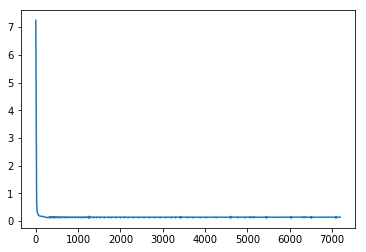

In [120]:
plt.plot([x * plot_every for x in range(len(train_plot_losses))], train_plot_losses)
plt.show()

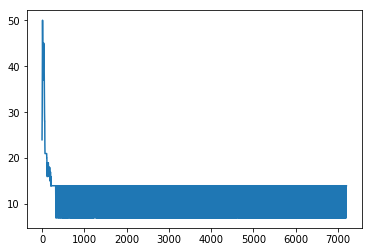

In [121]:
plt.plot(range(len(controller.times)), controller.times)
plt.show()

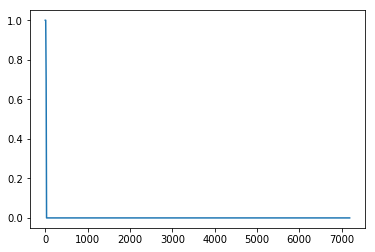

In [122]:
plt.plot([x * plot_every for x in range(len(validation_plot_losses))], validation_plot_losses)
plt.show()

In [124]:

cutoff = 0.7

def getBest(vec):
#     print("get best vec", vec)
    maxVal, index = torch.max(vec, 0)
#     print("MV, I", maxVal, index)
    if maxVal.data[0] > cutoff:
        return index.data[0]

def bestRegister(vec):
    index = getBest(vec)
    if index is not None:
        return "R" + str(1 + index)
    return "??"
    
def bestInstruction(vec):
    ops = [ 
        "STOP",
        "ZERO",
        "INC",
        "ADD",
        "SUB",
        "DEC",
        "MIN",
        "MAX",
        "READ",
        "WRITE",
        "JEZ"
    ]
    index = getBest(vec)
    if index is not None:
        return ops[index]
    return "??"
    
# registers = controller.registers

# # Add task
# orig_register = [6,2,0,1,0,0]
# orig_output = [4,3,5,3,4,5,5,5]
# orig_instruction = [8,8,10,5,2,10,9,0]
# orig_first = [4,3,3,3,4,2,2,5]
# orig_second = [5,5,0,5,5,1,4,5]
# orig_ir = [1,0,0,0,0,0,0,0]

# INC Task
orig_register = [6,0,0,0,0,0,0]
orig_first = [5,1,1,5,5,4,6]
orig_second = [6,0,6,3,6,2,6]
orig_output = [1,6,3,6,5,6,6]
orig_instruction = [8,10,2,9,2,10,0]

# # Access Task
# orig_register = [0,0,0]
# orig_first = [0,1,1,0,2]
# orig_second = [2,2,2,1,2]
# orig_output = [1,1,1,2,2]
# orig_instruction = [8,2,8,9,0]
# orig_ir = [1,0,0,0,0]


R, M = controller.registers.size()
    
def printProgram():   
    
    print("IR = " + str(getBest(controller.IR)))
    
    # Print registers
    for i in range(R):
        print("R" + str(i + 1) + " = " + str(getBest(controller.registers[i,:])))

    print()

    # Print the actual program
    for i in range (M):
        print(bestRegister(controller.output[:, i]) + " = " + 
              bestInstruction(controller.instruction[:, i]) + "(" +
              bestRegister(controller.first_arg[:, i]) + ", " +
              bestRegister(controller.second_arg[:, i]) + ")")




    
def compareOutput():
    # compare our output to theirs
    # we get one point for every matching number
    match_count = 0
    softmax = nn.Softmax(0)
    for i in range(R):
        if getBest(nn.Softmax(1)(controller.registers)[i,:]) == orig_register[i]:
            match_count += 1
    for i in range (M):
        if getBest(softmax(controller.output)[:, i]) == orig_output[i]:
            match_count += 1
        if getBest(softmax(controller.instruction)[:, i]) == orig_instruction[i]:
            match_count += 1
        if getBest(softmax(controller.first_arg)[:, i]) == orig_first[i]:
            match_count += 1
        if getBest(softmax(controller.second_arg)[:, i]) == orig_second[i]:
            match_count += 1
    if getBest(softmax(controller.IR)) == orig_ir:
        match_count += 1
    
    percent_orig = match_count / (len(orig_register) + len(orig_output) + 
                                           len(orig_instruction) + len(orig_first) + len(orig_second) + 1)
    # print("PERCENT MATCH", percent_orig)
    return percent_orig

    
printProgram()
compareOutput()

# Original Add Program   
# R1 = 6
# R2 = 2
# R3 = 0
# R4 = 1
# R5 = 0
# R6 = 0


# R5 = READ(R5, R6)
# R4 = READ(R4, R6)
# R6 = JEZ(R4, R1)
# R4 = DEC(R4, R6)
# R5 = INC(R5, R6)
# R6 = JEZ(R3, R2)
# R6 = WRITE(R3, R5)
# R6 = STOP(R6, R6)

#koala

IR = 0
R1 = 3
R2 = 0
R3 = 3
R4 = 3
R5 = 3
R6 = 1
R7 = 3

R4 = WRITE(R6, R3)
R7 = WRITE(R2, R3)
R4 = WRITE(R2, R3)
R7 = WRITE(R6, R3)
R4 = WRITE(R6, R3)
R7 = WRITE(R5, R3)
R7 = STOP(R2, R3)


0.3888888888888889

In [46]:
# Test a bunch of times
num_trials = 20

num_original_convergences = 0
num_0_losses = 0
num_better_convergences = 0
otherPrograms = []

num_examples = 100

for i in range(num_trials):
    print("Trial ", i)
    
    M = 5
    dataset = AccessTaskDataset(M, num_examples)
    data_loader = data.DataLoader(dataset, batch_size = 1) # Don't change this batch size.  You have been warned.

    controller = Controller(first_arg = first_arg, 
                        second_arg = second_arg, 
                        output = target, 
                        instruction = instruction, 
                        initial_registers = init_registers, 
                        stop_threshold = .9, 
                        multiplier = 1,
                        correctness_weight = 1, 
                        halting_weight = 5, 
                        efficiency_weight = 0.5, 
                        confidence_weight = 0.1, 
                        t_max = 50) 
    
    best_model, train_plot_losses, validation_plot_losses = training.train_model_anc(
        controller, 
        data_loader,  
        optimizer, 
        num_epochs = 15, 
        print_every = 5, 
        plot_every = plot_every, 
        deep_copy_desired = False, 
        validation_criterion = anc_validation_criterion, 
        batch_size = 1) # In the paper, they used batch sizes of 1 or 5
    
    percent_orig = compareOutput()
    if percent_orig > .99:
        num_original_convergences += 1
    end_losses = validation_plot_losses[-2:]
    if sum(end_losses) < .01:
        num_0_losses += 1
    if percent_orig < .99 and sum(end_losses) < .01:
        num_better_convergences += 1
        otherPrograms.append((controller.output, controller.instruction, controller.first_arg, controller.second_arg, controller.registers))
print("LOSS CONVERGENCES", num_0_losses * 1.0 / num_trials)
print("ORIG CONVERGENCES", num_original_convergences * 1.0 / num_trials)
print("BETTER CONVERGENCES", num_better_convergences * 1.0 / num_trials)

# penguin

Trial  0
Epoch 0/14
----------
Epoch Number: 0, Batch Number: 5, Validation Metric: 0.6000
Epoch Number: 0, Batch Number: 5, Training Loss: 2.0463
Time so far is 0m 0s
Epoch Number: 0, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 10, Training Loss: 2.5646
Time so far is 0m 0s
Epoch Number: 0, Batch Number: 15, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 15, Training Loss: 2.1954
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 20, Training Loss: 2.5111
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 25, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 25, Training Loss: 2.1241
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 30, Validation Metric: 0.6000
Epoch Number: 0, Batch Number: 30, Training Loss: 2.0498
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 35, Training Loss: 2.5305
Time so far is 0m 1

Epoch Number: 3, Batch Number: 5, Validation Metric: 0.6000
Epoch Number: 3, Batch Number: 5, Training Loss: 2.0463
Time so far is 0m 11s
Epoch Number: 3, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 10, Training Loss: 2.5646
Time so far is 0m 11s
Epoch Number: 3, Batch Number: 15, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 15, Training Loss: 2.1954
Time so far is 0m 12s
Epoch Number: 3, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 20, Training Loss: 2.5111
Time so far is 0m 12s
Epoch Number: 3, Batch Number: 25, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 25, Training Loss: 2.1241
Time so far is 0m 12s
Epoch Number: 3, Batch Number: 30, Validation Metric: 0.6000
Epoch Number: 3, Batch Number: 30, Training Loss: 2.0498
Time so far is 0m 12s
Epoch Number: 3, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 35, Training Loss: 2.5305
Time so far is 0m 12s
Epoch Number: 3, Batch

Epoch Number: 6, Batch Number: 5, Validation Metric: 0.6000
Epoch Number: 6, Batch Number: 5, Training Loss: 2.0463
Time so far is 0m 22s
Epoch Number: 6, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 10, Training Loss: 2.5646
Time so far is 0m 22s
Epoch Number: 6, Batch Number: 15, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 15, Training Loss: 2.1954
Time so far is 0m 22s
Epoch Number: 6, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 20, Training Loss: 2.5111
Time so far is 0m 23s
Epoch Number: 6, Batch Number: 25, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 25, Training Loss: 2.1241
Time so far is 0m 23s
Epoch Number: 6, Batch Number: 30, Validation Metric: 0.6000
Epoch Number: 6, Batch Number: 30, Training Loss: 2.0498
Time so far is 0m 23s
Epoch Number: 6, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 35, Training Loss: 2.5305
Time so far is 0m 23s
Epoch Number: 6, Batch

Epoch Number: 9, Batch Number: 5, Validation Metric: 0.6000
Epoch Number: 9, Batch Number: 5, Training Loss: 2.0463
Time so far is 0m 32s
Epoch Number: 9, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 10, Training Loss: 2.5646
Time so far is 0m 33s
Epoch Number: 9, Batch Number: 15, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 15, Training Loss: 2.1954
Time so far is 0m 33s
Epoch Number: 9, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 20, Training Loss: 2.5111
Time so far is 0m 33s
Epoch Number: 9, Batch Number: 25, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 25, Training Loss: 2.1241
Time so far is 0m 33s
Epoch Number: 9, Batch Number: 30, Validation Metric: 0.6000
Epoch Number: 9, Batch Number: 30, Training Loss: 2.0498
Time so far is 0m 33s
Epoch Number: 9, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 35, Training Loss: 2.5305
Time so far is 0m 33s
Epoch Number: 9, Batch

Epoch Number: 11, Batch Number: 95, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 95, Training Loss: 2.5164
Time so far is 0m 42s
Epoch Number: 11, Batch Number: 100, Validation Metric: 0.4000
Epoch Number: 11, Batch Number: 100, Training Loss: 1.7994
Time so far is 0m 43s
Epoch 12/14
----------
Epoch Number: 12, Batch Number: 5, Validation Metric: 0.6000
Epoch Number: 12, Batch Number: 5, Training Loss: 2.0463
Time so far is 0m 43s
Epoch Number: 12, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 10, Training Loss: 2.5646
Time so far is 0m 43s
Epoch Number: 12, Batch Number: 15, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 15, Training Loss: 2.1954
Time so far is 0m 43s
Epoch Number: 12, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 20, Training Loss: 2.5111
Time so far is 0m 43s
Epoch Number: 12, Batch Number: 25, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 25, Training Loss: 2.1241
Time 

Epoch Number: 14, Batch Number: 85, Validation Metric: 0.6000
Epoch Number: 14, Batch Number: 85, Training Loss: 2.2137
Time so far is 0m 53s
Epoch Number: 14, Batch Number: 90, Validation Metric: 0.6000
Epoch Number: 14, Batch Number: 90, Training Loss: 2.0396
Time so far is 0m 53s
Epoch Number: 14, Batch Number: 95, Validation Metric: 1.0000
Epoch Number: 14, Batch Number: 95, Training Loss: 2.5164
Time so far is 0m 53s
Epoch Number: 14, Batch Number: 100, Validation Metric: 0.4000
Epoch Number: 14, Batch Number: 100, Training Loss: 1.7994
Time so far is 0m 53s

Training complete in 0m 53s
Best loss: 2.298839
1111111 0
None
Variable containing:
 0.6488
 0.0878
 0.0878
 0.0878
 0.0878
[torch.FloatTensor of size 5]

0
1111111 1
None
Variable containing:
 0.6488
 0.0878
 0.0878
 0.0878
 0.0878
[torch.FloatTensor of size 5]

0
1111111 2
None
Variable containing:
 0.6488
 0.0878
 0.0878
 0.0878
 0.0878
[torch.FloatTensor of size 5]

0
3333333 0
3333333 1
3333333 2
3333333 3
3333333 4
PERC

Epoch Number: 2, Batch Number: 65, Validation Metric: 0.4000
Epoch Number: 2, Batch Number: 65, Training Loss: 2.0238
Time so far is 0m 9s
Epoch Number: 2, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 70, Training Loss: 2.2842
Time so far is 0m 9s
Epoch Number: 2, Batch Number: 75, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 75, Training Loss: 2.2857
Time so far is 0m 9s
Epoch Number: 2, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 80, Training Loss: 2.5449
Time so far is 0m 10s
Epoch Number: 2, Batch Number: 85, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 85, Training Loss: 2.3665
Time so far is 0m 10s
Epoch Number: 2, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 90, Training Loss: 2.3443
Time so far is 0m 10s
Epoch Number: 2, Batch Number: 95, Validation Metric: 0.6000
Epoch Number: 2, Batch Number: 95, Training Loss: 1.8663
Time so far is 0m 10s
Epoch Number: 2, Batch 

Epoch Number: 5, Batch Number: 65, Validation Metric: 0.4000
Epoch Number: 5, Batch Number: 65, Training Loss: 2.0238
Time so far is 0m 19s
Epoch Number: 5, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 70, Training Loss: 2.2842
Time so far is 0m 19s
Epoch Number: 5, Batch Number: 75, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 75, Training Loss: 2.2857
Time so far is 0m 19s
Epoch Number: 5, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 80, Training Loss: 2.5449
Time so far is 0m 20s
Epoch Number: 5, Batch Number: 85, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 85, Training Loss: 2.3665
Time so far is 0m 20s
Epoch Number: 5, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 90, Training Loss: 2.3443
Time so far is 0m 20s
Epoch Number: 5, Batch Number: 95, Validation Metric: 0.6000
Epoch Number: 5, Batch Number: 95, Training Loss: 1.8663
Time so far is 0m 20s
Epoch Number: 5, Bat

Epoch Number: 8, Batch Number: 65, Validation Metric: 0.4000
Epoch Number: 8, Batch Number: 65, Training Loss: 2.0238
Time so far is 0m 30s
Epoch Number: 8, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 70, Training Loss: 2.2842
Time so far is 0m 30s
Epoch Number: 8, Batch Number: 75, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 75, Training Loss: 2.2857
Time so far is 0m 30s
Epoch Number: 8, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 80, Training Loss: 2.5449
Time so far is 0m 30s
Epoch Number: 8, Batch Number: 85, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 85, Training Loss: 2.3665
Time so far is 0m 30s
Epoch Number: 8, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 90, Training Loss: 2.3443
Time so far is 0m 31s
Epoch Number: 8, Batch Number: 95, Validation Metric: 0.6000
Epoch Number: 8, Batch Number: 95, Training Loss: 1.8663
Time so far is 0m 31s
Epoch Number: 8, Bat

Epoch Number: 11, Batch Number: 55, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 55, Training Loss: 2.6751
Time so far is 0m 40s
Epoch Number: 11, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 60, Training Loss: 2.1449
Time so far is 0m 40s
Epoch Number: 11, Batch Number: 65, Validation Metric: 0.4000
Epoch Number: 11, Batch Number: 65, Training Loss: 2.0238
Time so far is 0m 40s
Epoch Number: 11, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 70, Training Loss: 2.2842
Time so far is 0m 41s
Epoch Number: 11, Batch Number: 75, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 75, Training Loss: 2.2857
Time so far is 0m 41s
Epoch Number: 11, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 80, Training Loss: 2.5449
Time so far is 0m 41s
Epoch Number: 11, Batch Number: 85, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 85, Training Loss: 2.3665
Time so far is 0m 41s
Epoch 

Epoch Number: 14, Batch Number: 50, Validation Metric: 0.6000
Epoch Number: 14, Batch Number: 50, Training Loss: 2.2101
Time so far is 0m 51s
Epoch Number: 14, Batch Number: 55, Validation Metric: 1.0000
Epoch Number: 14, Batch Number: 55, Training Loss: 2.6751
Time so far is 0m 51s
Epoch Number: 14, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 60, Training Loss: 2.1449
Time so far is 0m 51s
Epoch Number: 14, Batch Number: 65, Validation Metric: 0.4000
Epoch Number: 14, Batch Number: 65, Training Loss: 2.0238
Time so far is 0m 51s
Epoch Number: 14, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 70, Training Loss: 2.2842
Time so far is 0m 51s
Epoch Number: 14, Batch Number: 75, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 75, Training Loss: 2.2857
Time so far is 0m 52s
Epoch Number: 14, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 14, Batch Number: 80, Training Loss: 2.5449
Time so far is 0m 52s
Epoch 

Epoch Number: 2, Batch Number: 30, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 30, Training Loss: 2.1468
Time so far is 0m 8s
Epoch Number: 2, Batch Number: 35, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 35, Training Loss: 2.0983
Time so far is 0m 8s
Epoch Number: 2, Batch Number: 40, Validation Metric: 0.6000
Epoch Number: 2, Batch Number: 40, Training Loss: 2.1978
Time so far is 0m 8s
Epoch Number: 2, Batch Number: 45, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 45, Training Loss: 2.3139
Time so far is 0m 9s
Epoch Number: 2, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 50, Training Loss: 2.1271
Time so far is 0m 9s
Epoch Number: 2, Batch Number: 55, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 55, Training Loss: 2.1180
Time so far is 0m 9s
Epoch Number: 2, Batch Number: 60, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 60, Training Loss: 2.5157
Time so far is 0m 9s
Epoch Number: 2, Batch Numb

Epoch Number: 5, Batch Number: 30, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 30, Training Loss: 2.1468
Time so far is 0m 19s
Epoch Number: 5, Batch Number: 35, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 35, Training Loss: 2.0983
Time so far is 0m 19s
Epoch Number: 5, Batch Number: 40, Validation Metric: 0.6000
Epoch Number: 5, Batch Number: 40, Training Loss: 2.1978
Time so far is 0m 19s
Epoch Number: 5, Batch Number: 45, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 45, Training Loss: 2.3139
Time so far is 0m 19s
Epoch Number: 5, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 50, Training Loss: 2.1271
Time so far is 0m 19s
Epoch Number: 5, Batch Number: 55, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 55, Training Loss: 2.1180
Time so far is 0m 19s
Epoch Number: 5, Batch Number: 60, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 60, Training Loss: 2.5157
Time so far is 0m 20s
Epoch Number: 5, Bat

Epoch Number: 8, Batch Number: 30, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 30, Training Loss: 2.1468
Time so far is 0m 29s
Epoch Number: 8, Batch Number: 35, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 35, Training Loss: 2.0983
Time so far is 0m 29s
Epoch Number: 8, Batch Number: 40, Validation Metric: 0.6000
Epoch Number: 8, Batch Number: 40, Training Loss: 2.1978
Time so far is 0m 29s
Epoch Number: 8, Batch Number: 45, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 45, Training Loss: 2.3139
Time so far is 0m 29s
Epoch Number: 8, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 50, Training Loss: 2.1271
Time so far is 0m 30s
Epoch Number: 8, Batch Number: 55, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 55, Training Loss: 2.1180
Time so far is 0m 30s
Epoch Number: 8, Batch Number: 60, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 60, Training Loss: 2.5157
Time so far is 0m 30s
Epoch Number: 8, Bat

Epoch Number: 11, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 25, Training Loss: 2.5234
Time so far is 0m 40s
Epoch Number: 11, Batch Number: 30, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 30, Training Loss: 2.1468
Time so far is 0m 40s
Epoch Number: 11, Batch Number: 35, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 35, Training Loss: 2.0983
Time so far is 0m 40s
Epoch Number: 11, Batch Number: 40, Validation Metric: 0.6000
Epoch Number: 11, Batch Number: 40, Training Loss: 2.1978
Time so far is 0m 40s
Epoch Number: 11, Batch Number: 45, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 45, Training Loss: 2.3139
Time so far is 0m 40s
Epoch Number: 11, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 50, Training Loss: 2.1271
Time so far is 0m 40s
Epoch Number: 11, Batch Number: 55, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 55, Training Loss: 2.1180
Time so far is 0m 41s
Epoch 

Epoch Number: 14, Batch Number: 20, Validation Metric: 0.6000
Epoch Number: 14, Batch Number: 20, Training Loss: 2.2253
Time so far is 0m 50s
Epoch Number: 14, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 14, Batch Number: 25, Training Loss: 2.5234
Time so far is 0m 51s
Epoch Number: 14, Batch Number: 30, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 30, Training Loss: 2.1468
Time so far is 0m 51s
Epoch Number: 14, Batch Number: 35, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 35, Training Loss: 2.0983
Time so far is 0m 51s
Epoch Number: 14, Batch Number: 40, Validation Metric: 0.6000
Epoch Number: 14, Batch Number: 40, Training Loss: 2.1978
Time so far is 0m 51s
Epoch Number: 14, Batch Number: 45, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 45, Training Loss: 2.3139
Time so far is 0m 51s
Epoch Number: 14, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 50, Training Loss: 2.1271
Time so far is 0m 51s
Epoch 

Epoch Number: 1, Batch Number: 95, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 95, Training Loss: 2.3913
Time so far is 0m 7s
Epoch Number: 1, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 1, Batch Number: 100, Training Loss: 2.2982
Time so far is 0m 7s
Epoch 2/14
----------
Epoch Number: 2, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 5, Training Loss: 2.2810
Time so far is 0m 7s
Epoch Number: 2, Batch Number: 10, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 10, Training Loss: 2.2810
Time so far is 0m 7s
Epoch Number: 2, Batch Number: 15, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 15, Training Loss: 2.6860
Time so far is 0m 8s
Epoch Number: 2, Batch Number: 20, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 20, Training Loss: 2.1322
Time so far is 0m 8s
Epoch Number: 2, Batch Number: 25, Validation Metric: 0.6000
Epoch Number: 2, Batch Number: 25, Training Loss: 2.0874
Time so far is 0m 8s
Epoch

Epoch Number: 4, Batch Number: 90, Validation Metric: 0.8000
Epoch Number: 4, Batch Number: 90, Training Loss: 2.1154
Time so far is 0m 18s
Epoch Number: 4, Batch Number: 95, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 95, Training Loss: 2.3913
Time so far is 0m 18s
Epoch Number: 4, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 4, Batch Number: 100, Training Loss: 2.2982
Time so far is 0m 18s
Epoch 5/14
----------
Epoch Number: 5, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 5, Training Loss: 2.2810
Time so far is 0m 18s
Epoch Number: 5, Batch Number: 10, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 10, Training Loss: 2.2810
Time so far is 0m 18s
Epoch Number: 5, Batch Number: 15, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 15, Training Loss: 2.6860
Time so far is 0m 19s
Epoch Number: 5, Batch Number: 20, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 20, Training Loss: 2.1322
Time so far is 0m 19

Epoch Number: 7, Batch Number: 85, Validation Metric: 0.6000
Epoch Number: 7, Batch Number: 85, Training Loss: 2.2153
Time so far is 0m 29s
Epoch Number: 7, Batch Number: 90, Validation Metric: 0.8000
Epoch Number: 7, Batch Number: 90, Training Loss: 2.1154
Time so far is 0m 29s
Epoch Number: 7, Batch Number: 95, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 95, Training Loss: 2.3913
Time so far is 0m 29s
Epoch Number: 7, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 7, Batch Number: 100, Training Loss: 2.2982
Time so far is 0m 29s
Epoch 8/14
----------
Epoch Number: 8, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 5, Training Loss: 2.2810
Time so far is 0m 29s
Epoch Number: 8, Batch Number: 10, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 10, Training Loss: 2.2810
Time so far is 0m 29s
Epoch Number: 8, Batch Number: 15, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 15, Training Loss: 2.6860
Time so far is 0m 30

Epoch Number: 10, Batch Number: 75, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 75, Training Loss: 2.0816
Time so far is 0m 40s
Epoch Number: 10, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 80, Training Loss: 2.3600
Time so far is 0m 40s
Epoch Number: 10, Batch Number: 85, Validation Metric: 0.6000
Epoch Number: 10, Batch Number: 85, Training Loss: 2.2153
Time so far is 0m 40s
Epoch Number: 10, Batch Number: 90, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 90, Training Loss: 2.1154
Time so far is 0m 40s
Epoch Number: 10, Batch Number: 95, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 95, Training Loss: 2.3913
Time so far is 0m 40s
Epoch Number: 10, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 100, Training Loss: 2.2982
Time so far is 0m 40s
Epoch 11/14
----------
Epoch Number: 11, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 5, Training Loss: 2.2810
Time 

Epoch Number: 13, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 70, Training Loss: 2.4590
Time so far is 0m 50s
Epoch Number: 13, Batch Number: 75, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 75, Training Loss: 2.0816
Time so far is 0m 50s
Epoch Number: 13, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 80, Training Loss: 2.3600
Time so far is 0m 51s
Epoch Number: 13, Batch Number: 85, Validation Metric: 0.6000
Epoch Number: 13, Batch Number: 85, Training Loss: 2.2153
Time so far is 0m 51s
Epoch Number: 13, Batch Number: 90, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 90, Training Loss: 2.1154
Time so far is 0m 51s
Epoch Number: 13, Batch Number: 95, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 95, Training Loss: 2.3913
Time so far is 0m 51s
Epoch Number: 13, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 100, Training Loss: 2.2982
Time so far is 0m 51s
Epoc

Epoch Number: 1, Batch Number: 45, Validation Metric: 0.8000
Epoch Number: 1, Batch Number: 45, Training Loss: 2.2406
Time so far is 0m 6s
Epoch Number: 1, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 1, Batch Number: 50, Training Loss: 2.4709
Time so far is 0m 6s
Epoch Number: 1, Batch Number: 55, Validation Metric: 0.6000
Epoch Number: 1, Batch Number: 55, Training Loss: 2.0517
Time so far is 0m 6s
Epoch Number: 1, Batch Number: 60, Validation Metric: 0.2000
Epoch Number: 1, Batch Number: 60, Training Loss: 1.7730
Time so far is 0m 6s
Epoch Number: 1, Batch Number: 65, Validation Metric: 0.8000
Epoch Number: 1, Batch Number: 65, Training Loss: 2.2719
Time so far is 0m 6s
Epoch Number: 1, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 1, Batch Number: 70, Training Loss: 2.2986
Time so far is 0m 6s
Epoch Number: 1, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 75, Training Loss: 2.2001
Time so far is 0m 7s
Epoch Number: 1, Batch Numb

Epoch Number: 4, Batch Number: 45, Validation Metric: 0.8000
Epoch Number: 4, Batch Number: 45, Training Loss: 2.2406
Time so far is 0m 16s
Epoch Number: 4, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 4, Batch Number: 50, Training Loss: 2.4709
Time so far is 0m 16s
Epoch Number: 4, Batch Number: 55, Validation Metric: 0.6000
Epoch Number: 4, Batch Number: 55, Training Loss: 2.0517
Time so far is 0m 16s
Epoch Number: 4, Batch Number: 60, Validation Metric: 0.2000
Epoch Number: 4, Batch Number: 60, Training Loss: 1.7730
Time so far is 0m 16s
Epoch Number: 4, Batch Number: 65, Validation Metric: 0.8000
Epoch Number: 4, Batch Number: 65, Training Loss: 2.2719
Time so far is 0m 17s
Epoch Number: 4, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 4, Batch Number: 70, Training Loss: 2.2986
Time so far is 0m 17s
Epoch Number: 4, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 75, Training Loss: 2.2001
Time so far is 0m 17s
Epoch Number: 4, Bat

Epoch Number: 7, Batch Number: 45, Validation Metric: 0.8000
Epoch Number: 7, Batch Number: 45, Training Loss: 2.2406
Time so far is 0m 26s
Epoch Number: 7, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 7, Batch Number: 50, Training Loss: 2.4709
Time so far is 0m 27s
Epoch Number: 7, Batch Number: 55, Validation Metric: 0.6000
Epoch Number: 7, Batch Number: 55, Training Loss: 2.0517
Time so far is 0m 27s
Epoch Number: 7, Batch Number: 60, Validation Metric: 0.2000
Epoch Number: 7, Batch Number: 60, Training Loss: 1.7730
Time so far is 0m 27s
Epoch Number: 7, Batch Number: 65, Validation Metric: 0.8000
Epoch Number: 7, Batch Number: 65, Training Loss: 2.2719
Time so far is 0m 27s
Epoch Number: 7, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 7, Batch Number: 70, Training Loss: 2.2986
Time so far is 0m 27s
Epoch Number: 7, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 75, Training Loss: 2.2001
Time so far is 0m 27s
Epoch Number: 7, Bat

Epoch Number: 10, Batch Number: 35, Validation Metric: 0.6000
Epoch Number: 10, Batch Number: 35, Training Loss: 2.2131
Time so far is 0m 37s
Epoch Number: 10, Batch Number: 40, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 40, Training Loss: 2.5324
Time so far is 0m 37s
Epoch Number: 10, Batch Number: 45, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 45, Training Loss: 2.2406
Time so far is 0m 37s
Epoch Number: 10, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 50, Training Loss: 2.4709
Time so far is 0m 37s
Epoch Number: 10, Batch Number: 55, Validation Metric: 0.6000
Epoch Number: 10, Batch Number: 55, Training Loss: 2.0517
Time so far is 0m 37s
Epoch Number: 10, Batch Number: 60, Validation Metric: 0.2000
Epoch Number: 10, Batch Number: 60, Training Loss: 1.7730
Time so far is 0m 37s
Epoch Number: 10, Batch Number: 65, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 65, Training Loss: 2.2719
Time so far is 0m 38s
Epoch 

Epoch Number: 13, Batch Number: 30, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 30, Training Loss: 2.3561
Time so far is 0m 47s
Epoch Number: 13, Batch Number: 35, Validation Metric: 0.6000
Epoch Number: 13, Batch Number: 35, Training Loss: 2.2131
Time so far is 0m 47s
Epoch Number: 13, Batch Number: 40, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 40, Training Loss: 2.5324
Time so far is 0m 47s
Epoch Number: 13, Batch Number: 45, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 45, Training Loss: 2.2406
Time so far is 0m 47s
Epoch Number: 13, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 50, Training Loss: 2.4709
Time so far is 0m 48s
Epoch Number: 13, Batch Number: 55, Validation Metric: 0.6000
Epoch Number: 13, Batch Number: 55, Training Loss: 2.0517
Time so far is 0m 48s
Epoch Number: 13, Batch Number: 60, Validation Metric: 0.2000
Epoch Number: 13, Batch Number: 60, Training Loss: 1.7730
Time so far is 0m 48s
Epoch 

Epoch Number: 1, Batch Number: 10, Validation Metric: 0.4000
Epoch Number: 1, Batch Number: 10, Training Loss: 1.9890
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 15, Validation Metric: 0.8000
Epoch Number: 1, Batch Number: 15, Training Loss: 2.2948
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 20, Training Loss: 2.6901
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 25, Training Loss: 2.5355
Time so far is 0m 5s
Epoch Number: 1, Batch Number: 30, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 30, Training Loss: 2.7291
Time so far is 0m 5s
Epoch Number: 1, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 35, Training Loss: 2.3847
Time so far is 0m 5s
Epoch Number: 1, Batch Number: 40, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 40, Training Loss: 2.5091
Time so far is 0m 5s
Epoch Number: 1, Batch Numb

Epoch Number: 4, Batch Number: 10, Validation Metric: 0.4000
Epoch Number: 4, Batch Number: 10, Training Loss: 1.9890
Time so far is 0m 15s
Epoch Number: 4, Batch Number: 15, Validation Metric: 0.8000
Epoch Number: 4, Batch Number: 15, Training Loss: 2.2948
Time so far is 0m 15s
Epoch Number: 4, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 20, Training Loss: 2.6901
Time so far is 0m 15s
Epoch Number: 4, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 25, Training Loss: 2.5355
Time so far is 0m 16s
Epoch Number: 4, Batch Number: 30, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 30, Training Loss: 2.7291
Time so far is 0m 16s
Epoch Number: 4, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 35, Training Loss: 2.3847
Time so far is 0m 16s
Epoch Number: 4, Batch Number: 40, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 40, Training Loss: 2.5091
Time so far is 0m 16s
Epoch Number: 4, Bat

Epoch Number: 7, Batch Number: 10, Validation Metric: 0.4000
Epoch Number: 7, Batch Number: 10, Training Loss: 1.9890
Time so far is 0m 26s
Epoch Number: 7, Batch Number: 15, Validation Metric: 0.8000
Epoch Number: 7, Batch Number: 15, Training Loss: 2.2948
Time so far is 0m 26s
Epoch Number: 7, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 20, Training Loss: 2.6901
Time so far is 0m 26s
Epoch Number: 7, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 25, Training Loss: 2.5355
Time so far is 0m 27s
Epoch Number: 7, Batch Number: 30, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 30, Training Loss: 2.7291
Time so far is 0m 27s
Epoch Number: 7, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 35, Training Loss: 2.3847
Time so far is 0m 27s
Epoch Number: 7, Batch Number: 40, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 40, Training Loss: 2.5091
Time so far is 0m 27s
Epoch Number: 7, Bat

Epoch Number: 10, Batch Number: 10, Validation Metric: 0.4000
Epoch Number: 10, Batch Number: 10, Training Loss: 1.9890
Time so far is 0m 37s
Epoch Number: 10, Batch Number: 15, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 15, Training Loss: 2.2948
Time so far is 0m 37s
Epoch Number: 10, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 20, Training Loss: 2.6901
Time so far is 0m 37s
Epoch Number: 10, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 25, Training Loss: 2.5355
Time so far is 0m 37s
Epoch Number: 10, Batch Number: 30, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 30, Training Loss: 2.7291
Time so far is 0m 37s
Epoch Number: 10, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 35, Training Loss: 2.3847
Time so far is 0m 38s
Epoch Number: 10, Batch Number: 40, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 40, Training Loss: 2.5091
Time so far is 0m 38s
Epoch 

Epoch Number: 12, Batch Number: 100, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 100, Training Loss: 2.3674
Time so far is 0m 46s
Epoch 13/14
----------
Epoch Number: 13, Batch Number: 5, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 5, Training Loss: 2.5644
Time so far is 0m 46s
Epoch Number: 13, Batch Number: 10, Validation Metric: 0.4000
Epoch Number: 13, Batch Number: 10, Training Loss: 1.9890
Time so far is 0m 47s
Epoch Number: 13, Batch Number: 15, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 15, Training Loss: 2.2948
Time so far is 0m 47s
Epoch Number: 13, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 20, Training Loss: 2.6901
Time so far is 0m 47s
Epoch Number: 13, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 25, Training Loss: 2.5355
Time so far is 0m 47s
Epoch Number: 13, Batch Number: 30, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 30, Training Loss: 2.7291
Time 

Epoch Number: 0, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 80, Training Loss: 2.4410
Time so far is 0m 2s
Epoch Number: 0, Batch Number: 85, Validation Metric: 0.6000
Epoch Number: 0, Batch Number: 85, Training Loss: 2.2232
Time so far is 0m 2s
Epoch Number: 0, Batch Number: 90, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 90, Training Loss: 2.2952
Time so far is 0m 2s
Epoch Number: 0, Batch Number: 95, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 95, Training Loss: 2.7193
Time so far is 0m 2s
Epoch Number: 0, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 100, Training Loss: 2.2416
Time so far is 0m 2s
Epoch 1/14
----------
Epoch Number: 1, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 1, Batch Number: 5, Training Loss: 2.2653
Time so far is 0m 3s
Epoch Number: 1, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 10, Training Loss: 2.5238
Time so far is 0m 3s
Epoch

Epoch Number: 3, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 80, Training Loss: 2.4410
Time so far is 0m 9s
Epoch Number: 3, Batch Number: 85, Validation Metric: 0.6000
Epoch Number: 3, Batch Number: 85, Training Loss: 2.2232
Time so far is 0m 9s
Epoch Number: 3, Batch Number: 90, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 90, Training Loss: 2.2952
Time so far is 0m 10s
Epoch Number: 3, Batch Number: 95, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 95, Training Loss: 2.7193
Time so far is 0m 10s
Epoch Number: 3, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 100, Training Loss: 2.2416
Time so far is 0m 10s
Epoch 4/14
----------
Epoch Number: 4, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 4, Batch Number: 5, Training Loss: 2.2653
Time so far is 0m 10s
Epoch Number: 4, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 10, Training Loss: 2.5238
Time so far is 0m 10s


Epoch Number: 6, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 80, Training Loss: 2.4410
Time so far is 0m 17s
Epoch Number: 6, Batch Number: 85, Validation Metric: 0.6000
Epoch Number: 6, Batch Number: 85, Training Loss: 2.2232
Time so far is 0m 17s
Epoch Number: 6, Batch Number: 90, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 90, Training Loss: 2.2952
Time so far is 0m 17s
Epoch Number: 6, Batch Number: 95, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 95, Training Loss: 2.7193
Time so far is 0m 17s
Epoch Number: 6, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 100, Training Loss: 2.2416
Time so far is 0m 17s
Epoch 7/14
----------
Epoch Number: 7, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 7, Batch Number: 5, Training Loss: 2.2653
Time so far is 0m 17s
Epoch Number: 7, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 10, Training Loss: 2.5238
Time so far is 0m 17

Epoch Number: 9, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 80, Training Loss: 2.4410
Time so far is 0m 24s
Epoch Number: 9, Batch Number: 85, Validation Metric: 0.6000
Epoch Number: 9, Batch Number: 85, Training Loss: 2.2232
Time so far is 0m 24s
Epoch Number: 9, Batch Number: 90, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 90, Training Loss: 2.2952
Time so far is 0m 24s
Epoch Number: 9, Batch Number: 95, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 95, Training Loss: 2.7193
Time so far is 0m 24s
Epoch Number: 9, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 100, Training Loss: 2.2416
Time so far is 0m 24s
Epoch 10/14
----------
Epoch Number: 10, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 5, Training Loss: 2.2653
Time so far is 0m 25s
Epoch Number: 10, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 10, Training Loss: 2.5238
Time so far is 

Epoch Number: 12, Batch Number: 70, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 70, Training Loss: 2.6743
Time so far is 0m 31s
Epoch Number: 12, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 75, Training Loss: 2.5404
Time so far is 0m 31s
Epoch Number: 12, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 80, Training Loss: 2.4410
Time so far is 0m 31s
Epoch Number: 12, Batch Number: 85, Validation Metric: 0.6000
Epoch Number: 12, Batch Number: 85, Training Loss: 2.2232
Time so far is 0m 31s
Epoch Number: 12, Batch Number: 90, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 90, Training Loss: 2.2952
Time so far is 0m 31s
Epoch Number: 12, Batch Number: 95, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 95, Training Loss: 2.7193
Time so far is 0m 31s
Epoch Number: 12, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 100, Training Loss: 2.2416
Time so far is 0m 31s
Epoc

Epoch Number: 0, Batch Number: 50, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 50, Training Loss: 2.6605
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 55, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 55, Training Loss: 2.3717
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 60, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 60, Training Loss: 2.5184
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 65, Training Loss: 2.5474
Time so far is 0m 2s
Epoch Number: 0, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 70, Training Loss: 2.3194
Time so far is 0m 2s
Epoch Number: 0, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 75, Training Loss: 2.7019
Time so far is 0m 2s
Epoch Number: 0, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 80, Training Loss: 2.4528
Time so far is 0m 2s
Epoch Number: 0, Batch Numb

Epoch Number: 3, Batch Number: 50, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 50, Training Loss: 2.6605
Time so far is 0m 8s
Epoch Number: 3, Batch Number: 55, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 55, Training Loss: 2.3717
Time so far is 0m 9s
Epoch Number: 3, Batch Number: 60, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 60, Training Loss: 2.5184
Time so far is 0m 9s
Epoch Number: 3, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 65, Training Loss: 2.5474
Time so far is 0m 9s
Epoch Number: 3, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 70, Training Loss: 2.3194
Time so far is 0m 9s
Epoch Number: 3, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 75, Training Loss: 2.7019
Time so far is 0m 9s
Epoch Number: 3, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 80, Training Loss: 2.4528
Time so far is 0m 9s
Epoch Number: 3, Batch Numb

Epoch Number: 6, Batch Number: 50, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 50, Training Loss: 2.6605
Time so far is 0m 16s
Epoch Number: 6, Batch Number: 55, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 55, Training Loss: 2.3717
Time so far is 0m 16s
Epoch Number: 6, Batch Number: 60, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 60, Training Loss: 2.5184
Time so far is 0m 16s
Epoch Number: 6, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 65, Training Loss: 2.5474
Time so far is 0m 16s
Epoch Number: 6, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 70, Training Loss: 2.3194
Time so far is 0m 16s
Epoch Number: 6, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 75, Training Loss: 2.7019
Time so far is 0m 16s
Epoch Number: 6, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 80, Training Loss: 2.4528
Time so far is 0m 16s
Epoch Number: 6, Bat

Epoch Number: 9, Batch Number: 50, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 50, Training Loss: 2.6605
Time so far is 0m 23s
Epoch Number: 9, Batch Number: 55, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 55, Training Loss: 2.3717
Time so far is 0m 23s
Epoch Number: 9, Batch Number: 60, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 60, Training Loss: 2.5184
Time so far is 0m 23s
Epoch Number: 9, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 65, Training Loss: 2.5474
Time so far is 0m 23s
Epoch Number: 9, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 70, Training Loss: 2.3194
Time so far is 0m 23s
Epoch Number: 9, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 75, Training Loss: 2.7019
Time so far is 0m 23s
Epoch Number: 9, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 80, Training Loss: 2.4528
Time so far is 0m 23s
Epoch Number: 9, Bat

Epoch Number: 12, Batch Number: 40, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 40, Training Loss: 2.4780
Time so far is 0m 30s
Epoch Number: 12, Batch Number: 45, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 45, Training Loss: 2.7124
Time so far is 0m 30s
Epoch Number: 12, Batch Number: 50, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 50, Training Loss: 2.6605
Time so far is 0m 30s
Epoch Number: 12, Batch Number: 55, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 55, Training Loss: 2.3717
Time so far is 0m 30s
Epoch Number: 12, Batch Number: 60, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 60, Training Loss: 2.5184
Time so far is 0m 30s
Epoch Number: 12, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 65, Training Loss: 2.5474
Time so far is 0m 30s
Epoch Number: 12, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 70, Training Loss: 2.3194
Time so far is 0m 30s
Epoch 

Epoch Number: 0, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 20, Training Loss: 2.7145
Time so far is 0m 0s
Epoch Number: 0, Batch Number: 25, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 25, Training Loss: 2.2884
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 30, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 30, Training Loss: 2.2933
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 35, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 35, Training Loss: 2.2847
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 40, Validation Metric: 0.4000
Epoch Number: 0, Batch Number: 40, Training Loss: 1.9743
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 45, Validation Metric: 0.6000
Epoch Number: 0, Batch Number: 45, Training Loss: 1.7431
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 50, Training Loss: 2.3094
Time so far is 0m 1s
Epoch Number: 0, Batch Numb

Epoch Number: 3, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 20, Training Loss: 2.7145
Time so far is 0m 7s
Epoch Number: 3, Batch Number: 25, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 25, Training Loss: 2.2884
Time so far is 0m 8s
Epoch Number: 3, Batch Number: 30, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 30, Training Loss: 2.2933
Time so far is 0m 8s
Epoch Number: 3, Batch Number: 35, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 35, Training Loss: 2.2847
Time so far is 0m 8s
Epoch Number: 3, Batch Number: 40, Validation Metric: 0.4000
Epoch Number: 3, Batch Number: 40, Training Loss: 1.9743
Time so far is 0m 8s
Epoch Number: 3, Batch Number: 45, Validation Metric: 0.6000
Epoch Number: 3, Batch Number: 45, Training Loss: 1.7431
Time so far is 0m 8s
Epoch Number: 3, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 50, Training Loss: 2.3094
Time so far is 0m 8s
Epoch Number: 3, Batch Numb

Epoch Number: 6, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 20, Training Loss: 2.7145
Time so far is 0m 15s
Epoch Number: 6, Batch Number: 25, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 25, Training Loss: 2.2884
Time so far is 0m 15s
Epoch Number: 6, Batch Number: 30, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 30, Training Loss: 2.2933
Time so far is 0m 15s
Epoch Number: 6, Batch Number: 35, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 35, Training Loss: 2.2847
Time so far is 0m 15s
Epoch Number: 6, Batch Number: 40, Validation Metric: 0.4000
Epoch Number: 6, Batch Number: 40, Training Loss: 1.9743
Time so far is 0m 15s
Epoch Number: 6, Batch Number: 45, Validation Metric: 0.6000
Epoch Number: 6, Batch Number: 45, Training Loss: 1.7431
Time so far is 0m 15s
Epoch Number: 6, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 50, Training Loss: 2.3094
Time so far is 0m 15s
Epoch Number: 6, Bat

Epoch Number: 9, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 20, Training Loss: 2.7145
Time so far is 0m 22s
Epoch Number: 9, Batch Number: 25, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 25, Training Loss: 2.2884
Time so far is 0m 22s
Epoch Number: 9, Batch Number: 30, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 30, Training Loss: 2.2933
Time so far is 0m 22s
Epoch Number: 9, Batch Number: 35, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 35, Training Loss: 2.2847
Time so far is 0m 22s
Epoch Number: 9, Batch Number: 40, Validation Metric: 0.4000
Epoch Number: 9, Batch Number: 40, Training Loss: 1.9743
Time so far is 0m 22s
Epoch Number: 9, Batch Number: 45, Validation Metric: 0.6000
Epoch Number: 9, Batch Number: 45, Training Loss: 1.7431
Time so far is 0m 23s
Epoch Number: 9, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 50, Training Loss: 2.3094
Time so far is 0m 23s
Epoch Number: 9, Bat

Epoch Number: 12, Batch Number: 10, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 10, Training Loss: 2.2819
Time so far is 0m 29s
Epoch Number: 12, Batch Number: 15, Validation Metric: 0.6000
Epoch Number: 12, Batch Number: 15, Training Loss: 2.2407
Time so far is 0m 29s
Epoch Number: 12, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 20, Training Loss: 2.7145
Time so far is 0m 29s
Epoch Number: 12, Batch Number: 25, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 25, Training Loss: 2.2884
Time so far is 0m 29s
Epoch Number: 12, Batch Number: 30, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 30, Training Loss: 2.2933
Time so far is 0m 29s
Epoch Number: 12, Batch Number: 35, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 35, Training Loss: 2.2847
Time so far is 0m 29s
Epoch Number: 12, Batch Number: 40, Validation Metric: 0.4000
Epoch Number: 12, Batch Number: 40, Training Loss: 1.9743
Time so far is 0m 30s
Epoch 

Epoch Number: 14, Batch Number: 100, Validation Metric: 1.0000
Epoch Number: 14, Batch Number: 100, Training Loss: 2.6714
Time so far is 0m 36s

Training complete in 0m 36s
Best loss: 2.267513
1111111 0
None
Variable containing:
 0.6488
 0.0878
 0.0878
 0.0878
 0.0878
[torch.FloatTensor of size 5]

0
1111111 1
None
Variable containing:
 0.6488
 0.0878
 0.0878
 0.0878
 0.0878
[torch.FloatTensor of size 5]

0
1111111 2
None
Variable containing:
 0.6488
 0.0878
 0.0878
 0.0878
 0.0878
[torch.FloatTensor of size 5]

0
3333333 0
3333333 1
3333333 2
3333333 3
3333333 4
PERCENT MATCH 0.625
Trial  9
Epoch 0/14
----------
Epoch Number: 0, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 5, Training Loss: 2.4732
Time so far is 0m 0s
Epoch Number: 0, Batch Number: 10, Validation Metric: 0.6000
Epoch Number: 0, Batch Number: 10, Training Loss: 2.1894
Time so far is 0m 0s
Epoch Number: 0, Batch Number: 15, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 15, Trainin

Epoch Number: 2, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 80, Training Loss: 2.4567
Time so far is 0m 7s
Epoch Number: 2, Batch Number: 85, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 85, Training Loss: 2.1658
Time so far is 0m 7s
Epoch Number: 2, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 90, Training Loss: 2.6826
Time so far is 0m 7s
Epoch Number: 2, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 95, Training Loss: 2.1459
Time so far is 0m 7s
Epoch Number: 2, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 100, Training Loss: 2.3049
Time so far is 0m 7s
Epoch 3/14
----------
Epoch Number: 3, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 5, Training Loss: 2.4732
Time so far is 0m 7s
Epoch Number: 3, Batch Number: 10, Validation Metric: 0.6000
Epoch Number: 3, Batch Number: 10, Training Loss: 2.1894
Time so far is 0m 7s
Epoch

Epoch Number: 5, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 80, Training Loss: 2.4567
Time so far is 0m 14s
Epoch Number: 5, Batch Number: 85, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 85, Training Loss: 2.1658
Time so far is 0m 14s
Epoch Number: 5, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 90, Training Loss: 2.6826
Time so far is 0m 14s
Epoch Number: 5, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 95, Training Loss: 2.1459
Time so far is 0m 14s
Epoch Number: 5, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 100, Training Loss: 2.3049
Time so far is 0m 14s
Epoch 6/14
----------
Epoch Number: 6, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 5, Training Loss: 2.4732
Time so far is 0m 15s
Epoch Number: 6, Batch Number: 10, Validation Metric: 0.6000
Epoch Number: 6, Batch Number: 10, Training Loss: 2.1894
Time so far is 0m 15

Epoch Number: 8, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 80, Training Loss: 2.4567
Time so far is 0m 22s
Epoch Number: 8, Batch Number: 85, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 85, Training Loss: 2.1658
Time so far is 0m 22s
Epoch Number: 8, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 90, Training Loss: 2.6826
Time so far is 0m 22s
Epoch Number: 8, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 95, Training Loss: 2.1459
Time so far is 0m 22s
Epoch Number: 8, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 100, Training Loss: 2.3049
Time so far is 0m 23s
Epoch 9/14
----------
Epoch Number: 9, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 5, Training Loss: 2.4732
Time so far is 0m 23s
Epoch Number: 9, Batch Number: 10, Validation Metric: 0.6000
Epoch Number: 9, Batch Number: 10, Training Loss: 2.1894
Time so far is 0m 23

Epoch Number: 11, Batch Number: 70, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 70, Training Loss: 2.3430
Time so far is 0m 30s
Epoch Number: 11, Batch Number: 75, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 75, Training Loss: 2.2925
Time so far is 0m 30s
Epoch Number: 11, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 80, Training Loss: 2.4567
Time so far is 0m 30s
Epoch Number: 11, Batch Number: 85, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 85, Training Loss: 2.1658
Time so far is 0m 30s
Epoch Number: 11, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 90, Training Loss: 2.6826
Time so far is 0m 30s
Epoch Number: 11, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 95, Training Loss: 2.1459
Time so far is 0m 30s
Epoch Number: 11, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 100, Training Loss: 2.3049
Time so far is 0m 30s
Epoc

Epoch Number: 14, Batch Number: 60, Validation Metric: 0.6000
Epoch Number: 14, Batch Number: 60, Training Loss: 2.2210
Time so far is 0m 37s
Epoch Number: 14, Batch Number: 65, Validation Metric: 0.4000
Epoch Number: 14, Batch Number: 65, Training Loss: 1.9746
Time so far is 0m 37s
Epoch Number: 14, Batch Number: 70, Validation Metric: 1.0000
Epoch Number: 14, Batch Number: 70, Training Loss: 2.3430
Time so far is 0m 37s
Epoch Number: 14, Batch Number: 75, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 75, Training Loss: 2.2925
Time so far is 0m 37s
Epoch Number: 14, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 80, Training Loss: 2.4567
Time so far is 0m 37s
Epoch Number: 14, Batch Number: 85, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 85, Training Loss: 2.1658
Time so far is 0m 37s
Epoch Number: 14, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 14, Batch Number: 90, Training Loss: 2.6826
Time so far is 0m 37s
Epoch 

Epoch Number: 2, Batch Number: 40, Validation Metric: 0.6000
Epoch Number: 2, Batch Number: 40, Training Loss: 2.0748
Time so far is 0m 6s
Epoch Number: 2, Batch Number: 45, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 45, Training Loss: 2.1820
Time so far is 0m 6s
Epoch Number: 2, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 50, Training Loss: 2.3047
Time so far is 0m 6s
Epoch Number: 2, Batch Number: 55, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 55, Training Loss: 2.3694
Time so far is 0m 6s
Epoch Number: 2, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 60, Training Loss: 2.2947
Time so far is 0m 6s
Epoch Number: 2, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 65, Training Loss: 2.1959
Time so far is 0m 6s
Epoch Number: 2, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 70, Training Loss: 2.1246
Time so far is 0m 7s
Epoch Number: 2, Batch Numb

Epoch Number: 5, Batch Number: 40, Validation Metric: 0.6000
Epoch Number: 5, Batch Number: 40, Training Loss: 2.0748
Time so far is 0m 14s
Epoch Number: 5, Batch Number: 45, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 45, Training Loss: 2.1820
Time so far is 0m 14s
Epoch Number: 5, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 50, Training Loss: 2.3047
Time so far is 0m 14s
Epoch Number: 5, Batch Number: 55, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 55, Training Loss: 2.3694
Time so far is 0m 14s
Epoch Number: 5, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 60, Training Loss: 2.2947
Time so far is 0m 14s
Epoch Number: 5, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 65, Training Loss: 2.1959
Time so far is 0m 14s
Epoch Number: 5, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 70, Training Loss: 2.1246
Time so far is 0m 14s
Epoch Number: 5, Bat

Epoch Number: 8, Batch Number: 40, Validation Metric: 0.6000
Epoch Number: 8, Batch Number: 40, Training Loss: 2.0748
Time so far is 0m 21s
Epoch Number: 8, Batch Number: 45, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 45, Training Loss: 2.1820
Time so far is 0m 21s
Epoch Number: 8, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 50, Training Loss: 2.3047
Time so far is 0m 22s
Epoch Number: 8, Batch Number: 55, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 55, Training Loss: 2.3694
Time so far is 0m 22s
Epoch Number: 8, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 60, Training Loss: 2.2947
Time so far is 0m 22s
Epoch Number: 8, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 65, Training Loss: 2.1959
Time so far is 0m 22s
Epoch Number: 8, Batch Number: 70, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 70, Training Loss: 2.1246
Time so far is 0m 22s
Epoch Number: 8, Bat

Epoch Number: 11, Batch Number: 30, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 30, Training Loss: 2.7149
Time so far is 0m 29s
Epoch Number: 11, Batch Number: 35, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 35, Training Loss: 2.2904
Time so far is 0m 29s
Epoch Number: 11, Batch Number: 40, Validation Metric: 0.6000
Epoch Number: 11, Batch Number: 40, Training Loss: 2.0748
Time so far is 0m 29s
Epoch Number: 11, Batch Number: 45, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 45, Training Loss: 2.1820
Time so far is 0m 29s
Epoch Number: 11, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 50, Training Loss: 2.3047
Time so far is 0m 29s
Epoch Number: 11, Batch Number: 55, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 55, Training Loss: 2.3694
Time so far is 0m 29s
Epoch Number: 11, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 60, Training Loss: 2.2947
Time so far is 0m 29s
Epoch 

Epoch Number: 14, Batch Number: 20, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 20, Training Loss: 2.2934
Time so far is 0m 36s
Epoch Number: 14, Batch Number: 25, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 25, Training Loss: 2.2806
Time so far is 0m 36s
Epoch Number: 14, Batch Number: 30, Validation Metric: 1.0000
Epoch Number: 14, Batch Number: 30, Training Loss: 2.7149
Time so far is 0m 36s
Epoch Number: 14, Batch Number: 35, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 35, Training Loss: 2.2904
Time so far is 0m 36s
Epoch Number: 14, Batch Number: 40, Validation Metric: 0.6000
Epoch Number: 14, Batch Number: 40, Training Loss: 2.0748
Time so far is 0m 36s
Epoch Number: 14, Batch Number: 45, Validation Metric: 1.0000
Epoch Number: 14, Batch Number: 45, Training Loss: 2.1820
Time so far is 0m 36s
Epoch Number: 14, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 50, Training Loss: 2.3047
Time so far is 0m 37s
Epoch 

Epoch Number: 1, Batch Number: 100, Validation Metric: 0.6000
Epoch Number: 1, Batch Number: 100, Training Loss: 2.2339
Time so far is 0m 5s
Epoch 2/14
----------
Epoch Number: 2, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 5, Training Loss: 2.2613
Time so far is 0m 5s
Epoch Number: 2, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 10, Training Loss: 2.5233
Time so far is 0m 6s
Epoch Number: 2, Batch Number: 15, Validation Metric: 0.6000
Epoch Number: 2, Batch Number: 15, Training Loss: 2.0740
Time so far is 0m 6s
Epoch Number: 2, Batch Number: 20, Validation Metric: 0.6000
Epoch Number: 2, Batch Number: 20, Training Loss: 2.0918
Time so far is 0m 6s
Epoch Number: 2, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 25, Training Loss: 2.3328
Time so far is 0m 6s
Epoch Number: 2, Batch Number: 30, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 30, Training Loss: 2.5730
Time so far is 0m 6s
Epoch

Epoch Number: 4, Batch Number: 100, Validation Metric: 0.6000
Epoch Number: 4, Batch Number: 100, Training Loss: 2.2339
Time so far is 0m 13s
Epoch 5/14
----------
Epoch Number: 5, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 5, Training Loss: 2.2613
Time so far is 0m 13s
Epoch Number: 5, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 10, Training Loss: 2.5233
Time so far is 0m 13s
Epoch Number: 5, Batch Number: 15, Validation Metric: 0.6000
Epoch Number: 5, Batch Number: 15, Training Loss: 2.0740
Time so far is 0m 13s
Epoch Number: 5, Batch Number: 20, Validation Metric: 0.6000
Epoch Number: 5, Batch Number: 20, Training Loss: 2.0918
Time so far is 0m 13s
Epoch Number: 5, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 25, Training Loss: 2.3328
Time so far is 0m 14s
Epoch Number: 5, Batch Number: 30, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 30, Training Loss: 2.5730
Time so far is 0m 14

Epoch Number: 7, Batch Number: 100, Validation Metric: 0.6000
Epoch Number: 7, Batch Number: 100, Training Loss: 2.2339
Time so far is 0m 21s
Epoch 8/14
----------
Epoch Number: 8, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 5, Training Loss: 2.2613
Time so far is 0m 21s
Epoch Number: 8, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 10, Training Loss: 2.5233
Time so far is 0m 21s
Epoch Number: 8, Batch Number: 15, Validation Metric: 0.6000
Epoch Number: 8, Batch Number: 15, Training Loss: 2.0740
Time so far is 0m 21s
Epoch Number: 8, Batch Number: 20, Validation Metric: 0.6000
Epoch Number: 8, Batch Number: 20, Training Loss: 2.0918
Time so far is 0m 21s
Epoch Number: 8, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 25, Training Loss: 2.3328
Time so far is 0m 21s
Epoch Number: 8, Batch Number: 30, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 30, Training Loss: 2.5730
Time so far is 0m 22

Epoch Number: 10, Batch Number: 90, Validation Metric: 0.4000
Epoch Number: 10, Batch Number: 90, Training Loss: 1.8124
Time so far is 0m 28s
Epoch Number: 10, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 95, Training Loss: 2.1304
Time so far is 0m 28s
Epoch Number: 10, Batch Number: 100, Validation Metric: 0.6000
Epoch Number: 10, Batch Number: 100, Training Loss: 2.2339
Time so far is 0m 28s
Epoch 11/14
----------
Epoch Number: 11, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 5, Training Loss: 2.2613
Time so far is 0m 28s
Epoch Number: 11, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 10, Training Loss: 2.5233
Time so far is 0m 28s
Epoch Number: 11, Batch Number: 15, Validation Metric: 0.6000
Epoch Number: 11, Batch Number: 15, Training Loss: 2.0740
Time so far is 0m 28s
Epoch Number: 11, Batch Number: 20, Validation Metric: 0.6000
Epoch Number: 11, Batch Number: 20, Training Loss: 2.0918
Time 

Epoch Number: 13, Batch Number: 80, Validation Metric: 0.6000
Epoch Number: 13, Batch Number: 80, Training Loss: 2.2320
Time so far is 0m 35s
Epoch Number: 13, Batch Number: 85, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 85, Training Loss: 2.1112
Time so far is 0m 35s
Epoch Number: 13, Batch Number: 90, Validation Metric: 0.4000
Epoch Number: 13, Batch Number: 90, Training Loss: 1.8124
Time so far is 0m 35s
Epoch Number: 13, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 95, Training Loss: 2.1304
Time so far is 0m 35s
Epoch Number: 13, Batch Number: 100, Validation Metric: 0.6000
Epoch Number: 13, Batch Number: 100, Training Loss: 2.2339
Time so far is 0m 36s
Epoch 14/14
----------
Epoch Number: 14, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 5, Training Loss: 2.2613
Time so far is 0m 36s
Epoch Number: 14, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 14, Batch Number: 10, Training Loss: 2.5233
Time 

Epoch Number: 1, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 1, Batch Number: 60, Training Loss: 2.1343
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 65, Validation Metric: 0.6000
Epoch Number: 1, Batch Number: 65, Training Loss: 2.0435
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 70, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 70, Training Loss: 2.5187
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 75, Training Loss: 2.5301
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 80, Validation Metric: 0.6000
Epoch Number: 1, Batch Number: 80, Training Loss: 2.0638
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 85, Validation Metric: 0.8000
Epoch Number: 1, Batch Number: 85, Training Loss: 2.4619
Time so far is 0m 5s
Epoch Number: 1, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 90, Training Loss: 2.2104
Time so far is 0m 5s
Epoch Number: 1, Batch Numb

Epoch Number: 4, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 4, Batch Number: 60, Training Loss: 2.1343
Time so far is 0m 11s
Epoch Number: 4, Batch Number: 65, Validation Metric: 0.6000
Epoch Number: 4, Batch Number: 65, Training Loss: 2.0435
Time so far is 0m 11s
Epoch Number: 4, Batch Number: 70, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 70, Training Loss: 2.5187
Time so far is 0m 11s
Epoch Number: 4, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 75, Training Loss: 2.5301
Time so far is 0m 12s
Epoch Number: 4, Batch Number: 80, Validation Metric: 0.6000
Epoch Number: 4, Batch Number: 80, Training Loss: 2.0638
Time so far is 0m 12s
Epoch Number: 4, Batch Number: 85, Validation Metric: 0.8000
Epoch Number: 4, Batch Number: 85, Training Loss: 2.4619
Time so far is 0m 12s
Epoch Number: 4, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 90, Training Loss: 2.2104
Time so far is 0m 12s
Epoch Number: 4, Bat

Epoch Number: 7, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 7, Batch Number: 60, Training Loss: 2.1343
Time so far is 0m 19s
Epoch Number: 7, Batch Number: 65, Validation Metric: 0.6000
Epoch Number: 7, Batch Number: 65, Training Loss: 2.0435
Time so far is 0m 19s
Epoch Number: 7, Batch Number: 70, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 70, Training Loss: 2.5187
Time so far is 0m 19s
Epoch Number: 7, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 75, Training Loss: 2.5301
Time so far is 0m 19s
Epoch Number: 7, Batch Number: 80, Validation Metric: 0.6000
Epoch Number: 7, Batch Number: 80, Training Loss: 2.0638
Time so far is 0m 19s
Epoch Number: 7, Batch Number: 85, Validation Metric: 0.8000
Epoch Number: 7, Batch Number: 85, Training Loss: 2.4619
Time so far is 0m 19s
Epoch Number: 7, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 90, Training Loss: 2.2104
Time so far is 0m 20s
Epoch Number: 7, Bat

Epoch Number: 10, Batch Number: 50, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 50, Training Loss: 2.3986
Time so far is 0m 26s
Epoch Number: 10, Batch Number: 55, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 55, Training Loss: 2.5670
Time so far is 0m 26s
Epoch Number: 10, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 60, Training Loss: 2.1343
Time so far is 0m 27s
Epoch Number: 10, Batch Number: 65, Validation Metric: 0.6000
Epoch Number: 10, Batch Number: 65, Training Loss: 2.0435
Time so far is 0m 27s
Epoch Number: 10, Batch Number: 70, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 70, Training Loss: 2.5187
Time so far is 0m 27s
Epoch Number: 10, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 75, Training Loss: 2.5301
Time so far is 0m 27s
Epoch Number: 10, Batch Number: 80, Validation Metric: 0.6000
Epoch Number: 10, Batch Number: 80, Training Loss: 2.0638
Time so far is 0m 27s
Epoch 

Epoch Number: 13, Batch Number: 40, Validation Metric: 0.6000
Epoch Number: 13, Batch Number: 40, Training Loss: 2.2221
Time so far is 0m 33s
Epoch Number: 13, Batch Number: 45, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 45, Training Loss: 2.4644
Time so far is 0m 34s
Epoch Number: 13, Batch Number: 50, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 50, Training Loss: 2.3986
Time so far is 0m 34s
Epoch Number: 13, Batch Number: 55, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 55, Training Loss: 2.5670
Time so far is 0m 34s
Epoch Number: 13, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 60, Training Loss: 2.1343
Time so far is 0m 34s
Epoch Number: 13, Batch Number: 65, Validation Metric: 0.6000
Epoch Number: 13, Batch Number: 65, Training Loss: 2.0435
Time so far is 0m 34s
Epoch Number: 13, Batch Number: 70, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 70, Training Loss: 2.5187
Time so far is 0m 34s
Epoch 

Epoch Number: 1, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 20, Training Loss: 2.5567
Time so far is 0m 3s
Epoch Number: 1, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 25, Training Loss: 2.5338
Time so far is 0m 3s
Epoch Number: 1, Batch Number: 30, Validation Metric: 0.8000
Epoch Number: 1, Batch Number: 30, Training Loss: 2.4277
Time so far is 0m 3s
Epoch Number: 1, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 35, Training Loss: 2.3762
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 40, Validation Metric: 0.8000
Epoch Number: 1, Batch Number: 40, Training Loss: 2.3124
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 45, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 45, Training Loss: 2.5513
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 1, Batch Number: 50, Training Loss: 2.1070
Time so far is 0m 4s
Epoch Number: 1, Batch Numb

Epoch Number: 4, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 20, Training Loss: 2.5567
Time so far is 0m 13s
Epoch Number: 4, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 25, Training Loss: 2.5338
Time so far is 0m 14s
Epoch Number: 4, Batch Number: 30, Validation Metric: 0.8000
Epoch Number: 4, Batch Number: 30, Training Loss: 2.4277
Time so far is 0m 14s
Epoch Number: 4, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 35, Training Loss: 2.3762
Time so far is 0m 14s
Epoch Number: 4, Batch Number: 40, Validation Metric: 0.8000
Epoch Number: 4, Batch Number: 40, Training Loss: 2.3124
Time so far is 0m 14s
Epoch Number: 4, Batch Number: 45, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 45, Training Loss: 2.5513
Time so far is 0m 14s
Epoch Number: 4, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 4, Batch Number: 50, Training Loss: 2.1070
Time so far is 0m 14s
Epoch Number: 4, Bat

Epoch Number: 7, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 20, Training Loss: 2.5567
Time so far is 0m 24s
Epoch Number: 7, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 25, Training Loss: 2.5338
Time so far is 0m 24s
Epoch Number: 7, Batch Number: 30, Validation Metric: 0.8000
Epoch Number: 7, Batch Number: 30, Training Loss: 2.4277
Time so far is 0m 24s
Epoch Number: 7, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 35, Training Loss: 2.3762
Time so far is 0m 24s
Epoch Number: 7, Batch Number: 40, Validation Metric: 0.8000
Epoch Number: 7, Batch Number: 40, Training Loss: 2.3124
Time so far is 0m 24s
Epoch Number: 7, Batch Number: 45, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 45, Training Loss: 2.5513
Time so far is 0m 24s
Epoch Number: 7, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 7, Batch Number: 50, Training Loss: 2.1070
Time so far is 0m 25s
Epoch Number: 7, Bat

Epoch Number: 10, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 20, Training Loss: 2.5567
Time so far is 0m 33s
Epoch Number: 10, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 25, Training Loss: 2.5338
Time so far is 0m 33s
Epoch Number: 10, Batch Number: 30, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 30, Training Loss: 2.4277
Time so far is 0m 34s
Epoch Number: 10, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 35, Training Loss: 2.3762
Time so far is 0m 34s
Epoch Number: 10, Batch Number: 40, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 40, Training Loss: 2.3124
Time so far is 0m 34s
Epoch Number: 10, Batch Number: 45, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 45, Training Loss: 2.5513
Time so far is 0m 34s
Epoch Number: 10, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 50, Training Loss: 2.1070
Time so far is 0m 34s
Epoch 

Epoch Number: 13, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 10, Training Loss: 2.1897
Time so far is 0m 43s
Epoch Number: 13, Batch Number: 15, Validation Metric: 0.4000
Epoch Number: 13, Batch Number: 15, Training Loss: 1.9885
Time so far is 0m 43s
Epoch Number: 13, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 20, Training Loss: 2.5567
Time so far is 0m 43s
Epoch Number: 13, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 25, Training Loss: 2.5338
Time so far is 0m 43s
Epoch Number: 13, Batch Number: 30, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 30, Training Loss: 2.4277
Time so far is 0m 43s
Epoch Number: 13, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 35, Training Loss: 2.3762
Time so far is 0m 44s
Epoch Number: 13, Batch Number: 40, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 40, Training Loss: 2.3124
Time so far is 0m 44s
Epoch 

Epoch Number: 0, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 90, Training Loss: 2.5004
Time so far is 0m 3s
Epoch Number: 0, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 95, Training Loss: 2.2776
Time so far is 0m 3s
Epoch Number: 0, Batch Number: 100, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 100, Training Loss: 2.5514
Time so far is 0m 3s
Epoch 1/14
----------
Epoch Number: 1, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 1, Batch Number: 5, Training Loss: 2.1349
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 10, Validation Metric: 0.4000
Epoch Number: 1, Batch Number: 10, Training Loss: 1.9614
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 15, Validation Metric: 0.6000
Epoch Number: 1, Batch Number: 15, Training Loss: 2.2276
Time so far is 0m 4s
Epoch Number: 1, Batch Number: 20, Validation Metric: 0.6000
Epoch Number: 1, Batch Number: 20, Training Loss: 2.0668
Time so far is 0m 4s
Epoch

Epoch Number: 3, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 90, Training Loss: 2.5004
Time so far is 0m 13s
Epoch Number: 3, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 95, Training Loss: 2.2776
Time so far is 0m 13s
Epoch Number: 3, Batch Number: 100, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 100, Training Loss: 2.5514
Time so far is 0m 13s
Epoch 4/14
----------
Epoch Number: 4, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 4, Batch Number: 5, Training Loss: 2.1349
Time so far is 0m 13s
Epoch Number: 4, Batch Number: 10, Validation Metric: 0.4000
Epoch Number: 4, Batch Number: 10, Training Loss: 1.9614
Time so far is 0m 14s
Epoch Number: 4, Batch Number: 15, Validation Metric: 0.6000
Epoch Number: 4, Batch Number: 15, Training Loss: 2.2276
Time so far is 0m 14s
Epoch Number: 4, Batch Number: 20, Validation Metric: 0.6000
Epoch Number: 4, Batch Number: 20, Training Loss: 2.0668
Time so far is 0m 14

Epoch Number: 6, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 90, Training Loss: 2.5004
Time so far is 0m 22s
Epoch Number: 6, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 95, Training Loss: 2.2776
Time so far is 0m 22s
Epoch Number: 6, Batch Number: 100, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 100, Training Loss: 2.5514
Time so far is 0m 23s
Epoch 7/14
----------
Epoch Number: 7, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 7, Batch Number: 5, Training Loss: 2.1349
Time so far is 0m 23s
Epoch Number: 7, Batch Number: 10, Validation Metric: 0.4000
Epoch Number: 7, Batch Number: 10, Training Loss: 1.9614
Time so far is 0m 23s
Epoch Number: 7, Batch Number: 15, Validation Metric: 0.6000
Epoch Number: 7, Batch Number: 15, Training Loss: 2.2276
Time so far is 0m 23s
Epoch Number: 7, Batch Number: 20, Validation Metric: 0.6000
Epoch Number: 7, Batch Number: 20, Training Loss: 2.0668
Time so far is 0m 23

Epoch Number: 9, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 90, Training Loss: 2.5004
Time so far is 0m 33s
Epoch Number: 9, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 95, Training Loss: 2.2776
Time so far is 0m 33s
Epoch Number: 9, Batch Number: 100, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 100, Training Loss: 2.5514
Time so far is 0m 33s
Epoch 10/14
----------
Epoch Number: 10, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 5, Training Loss: 2.1349
Time so far is 0m 33s
Epoch Number: 10, Batch Number: 10, Validation Metric: 0.4000
Epoch Number: 10, Batch Number: 10, Training Loss: 1.9614
Time so far is 0m 33s
Epoch Number: 10, Batch Number: 15, Validation Metric: 0.6000
Epoch Number: 10, Batch Number: 15, Training Loss: 2.2276
Time so far is 0m 34s
Epoch Number: 10, Batch Number: 20, Validation Metric: 0.6000
Epoch Number: 10, Batch Number: 20, Training Loss: 2.0668
Time so far

Epoch Number: 12, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 80, Training Loss: 2.1916
Time so far is 0m 42s
Epoch Number: 12, Batch Number: 85, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 85, Training Loss: 2.5397
Time so far is 0m 43s
Epoch Number: 12, Batch Number: 90, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 90, Training Loss: 2.5004
Time so far is 0m 43s
Epoch Number: 12, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 95, Training Loss: 2.2776
Time so far is 0m 43s
Epoch Number: 12, Batch Number: 100, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 100, Training Loss: 2.5514
Time so far is 0m 43s
Epoch 13/14
----------
Epoch Number: 13, Batch Number: 5, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 5, Training Loss: 2.1349
Time so far is 0m 43s
Epoch Number: 13, Batch Number: 10, Validation Metric: 0.4000
Epoch Number: 13, Batch Number: 10, Training Loss: 1.9614
Time 

Epoch Number: 0, Batch Number: 55, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 55, Training Loss: 2.4526
Time so far is 0m 2s
Epoch Number: 0, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 60, Training Loss: 2.1473
Time so far is 0m 2s
Epoch Number: 0, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 65, Training Loss: 2.3516
Time so far is 0m 2s
Epoch Number: 0, Batch Number: 70, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 70, Training Loss: 2.5060
Time so far is 0m 3s
Epoch Number: 0, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 75, Training Loss: 2.5416
Time so far is 0m 3s
Epoch Number: 0, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 80, Training Loss: 2.3624
Time so far is 0m 3s
Epoch Number: 0, Batch Number: 85, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 85, Training Loss: 2.1444
Time so far is 0m 3s
Epoch Number: 0, Batch Numb

Epoch Number: 3, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 50, Training Loss: 2.4624
Time so far is 0m 12s
Epoch Number: 3, Batch Number: 55, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 55, Training Loss: 2.4526
Time so far is 0m 12s
Epoch Number: 3, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 60, Training Loss: 2.1473
Time so far is 0m 12s
Epoch Number: 3, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 65, Training Loss: 2.3516
Time so far is 0m 12s
Epoch Number: 3, Batch Number: 70, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 70, Training Loss: 2.5060
Time so far is 0m 13s
Epoch Number: 3, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 75, Training Loss: 2.5416
Time so far is 0m 13s
Epoch Number: 3, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 80, Training Loss: 2.3624
Time so far is 0m 13s
Epoch Number: 3, Bat

Epoch Number: 6, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 50, Training Loss: 2.4624
Time so far is 0m 22s
Epoch Number: 6, Batch Number: 55, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 55, Training Loss: 2.4526
Time so far is 0m 22s
Epoch Number: 6, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 60, Training Loss: 2.1473
Time so far is 0m 23s
Epoch Number: 6, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 65, Training Loss: 2.3516
Time so far is 0m 23s
Epoch Number: 6, Batch Number: 70, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 70, Training Loss: 2.5060
Time so far is 0m 23s
Epoch Number: 6, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 75, Training Loss: 2.5416
Time so far is 0m 23s
Epoch Number: 6, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 80, Training Loss: 2.3624
Time so far is 0m 23s
Epoch Number: 6, Bat

Epoch Number: 9, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 50, Training Loss: 2.4624
Time so far is 0m 33s
Epoch Number: 9, Batch Number: 55, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 55, Training Loss: 2.4526
Time so far is 0m 33s
Epoch Number: 9, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 60, Training Loss: 2.1473
Time so far is 0m 33s
Epoch Number: 9, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 65, Training Loss: 2.3516
Time so far is 0m 33s
Epoch Number: 9, Batch Number: 70, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 70, Training Loss: 2.5060
Time so far is 0m 33s
Epoch Number: 9, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 75, Training Loss: 2.5416
Time so far is 0m 33s
Epoch Number: 9, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 80, Training Loss: 2.3624
Time so far is 0m 34s
Epoch Number: 9, Bat

Epoch Number: 12, Batch Number: 40, Validation Metric: 0.6000
Epoch Number: 12, Batch Number: 40, Training Loss: 2.0269
Time so far is 0m 43s
Epoch Number: 12, Batch Number: 45, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 45, Training Loss: 2.1405
Time so far is 0m 43s
Epoch Number: 12, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 50, Training Loss: 2.4624
Time so far is 0m 43s
Epoch Number: 12, Batch Number: 55, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 55, Training Loss: 2.4526
Time so far is 0m 44s
Epoch Number: 12, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 60, Training Loss: 2.1473
Time so far is 0m 44s
Epoch Number: 12, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 65, Training Loss: 2.3516
Time so far is 0m 44s
Epoch Number: 12, Batch Number: 70, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 70, Training Loss: 2.5060
Time so far is 0m 44s
Epoch 

Epoch Number: 0, Batch Number: 15, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 15, Training Loss: 2.4341
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 20, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 20, Training Loss: 2.3104
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 25, Training Loss: 2.3430
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 30, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 30, Training Loss: 2.5058
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 35, Validation Metric: 0.8000
Epoch Number: 0, Batch Number: 35, Training Loss: 1.9446
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 40, Validation Metric: 0.6000
Epoch Number: 0, Batch Number: 40, Training Loss: 1.7405
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 45, Validation Metric: 1.0000
Epoch Number: 0, Batch Number: 45, Training Loss: 2.2147
Time so far is 0m 2s
Epoch Number: 0, Batch Numb

Epoch Number: 3, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 10, Training Loss: 2.3845
Time so far is 0m 11s
Epoch Number: 3, Batch Number: 15, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 15, Training Loss: 2.4341
Time so far is 0m 11s
Epoch Number: 3, Batch Number: 20, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 20, Training Loss: 2.3104
Time so far is 0m 11s
Epoch Number: 3, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 25, Training Loss: 2.3430
Time so far is 0m 11s
Epoch Number: 3, Batch Number: 30, Validation Metric: 1.0000
Epoch Number: 3, Batch Number: 30, Training Loss: 2.5058
Time so far is 0m 11s
Epoch Number: 3, Batch Number: 35, Validation Metric: 0.8000
Epoch Number: 3, Batch Number: 35, Training Loss: 1.9446
Time so far is 0m 11s
Epoch Number: 3, Batch Number: 40, Validation Metric: 0.6000
Epoch Number: 3, Batch Number: 40, Training Loss: 1.7405
Time so far is 0m 12s
Epoch Number: 3, Bat

Epoch Number: 6, Batch Number: 5, Validation Metric: 0.6000
Epoch Number: 6, Batch Number: 5, Training Loss: 2.2518
Time so far is 0m 21s
Epoch Number: 6, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 10, Training Loss: 2.3845
Time so far is 0m 21s
Epoch Number: 6, Batch Number: 15, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 15, Training Loss: 2.4341
Time so far is 0m 21s
Epoch Number: 6, Batch Number: 20, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 20, Training Loss: 2.3104
Time so far is 0m 22s
Epoch Number: 6, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 25, Training Loss: 2.3430
Time so far is 0m 22s
Epoch Number: 6, Batch Number: 30, Validation Metric: 1.0000
Epoch Number: 6, Batch Number: 30, Training Loss: 2.5058
Time so far is 0m 22s
Epoch Number: 6, Batch Number: 35, Validation Metric: 0.8000
Epoch Number: 6, Batch Number: 35, Training Loss: 1.9446
Time so far is 0m 22s
Epoch Number: 6, Batch

Epoch Number: 8, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 100, Training Loss: 2.3134
Time so far is 0m 32s
Epoch 9/14
----------
Epoch Number: 9, Batch Number: 5, Validation Metric: 0.6000
Epoch Number: 9, Batch Number: 5, Training Loss: 2.2518
Time so far is 0m 32s
Epoch Number: 9, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 10, Training Loss: 2.3845
Time so far is 0m 32s
Epoch Number: 9, Batch Number: 15, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 15, Training Loss: 2.4341
Time so far is 0m 32s
Epoch Number: 9, Batch Number: 20, Validation Metric: 0.8000
Epoch Number: 9, Batch Number: 20, Training Loss: 2.3104
Time so far is 0m 32s
Epoch Number: 9, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 25, Training Loss: 2.3430
Time so far is 0m 33s
Epoch Number: 9, Batch Number: 30, Validation Metric: 1.0000
Epoch Number: 9, Batch Number: 30, Training Loss: 2.5058
Time so far is 0m 33

Epoch Number: 11, Batch Number: 90, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 90, Training Loss: 2.3062
Time so far is 0m 42s
Epoch Number: 11, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 95, Training Loss: 2.2858
Time so far is 0m 42s
Epoch Number: 11, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 100, Training Loss: 2.3134
Time so far is 0m 42s
Epoch 12/14
----------
Epoch Number: 12, Batch Number: 5, Validation Metric: 0.6000
Epoch Number: 12, Batch Number: 5, Training Loss: 2.2518
Time so far is 0m 42s
Epoch Number: 12, Batch Number: 10, Validation Metric: 1.0000
Epoch Number: 12, Batch Number: 10, Training Loss: 2.3845
Time so far is 0m 42s
Epoch Number: 12, Batch Number: 15, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 15, Training Loss: 2.4341
Time so far is 0m 43s
Epoch Number: 12, Batch Number: 20, Validation Metric: 0.8000
Epoch Number: 12, Batch Number: 20, Training Loss: 2.3104
Time 

Epoch Number: 14, Batch Number: 85, Validation Metric: 0.4000
Epoch Number: 14, Batch Number: 85, Training Loss: 1.6588
Time so far is 0m 52s
Epoch Number: 14, Batch Number: 90, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 90, Training Loss: 2.3062
Time so far is 0m 52s
Epoch Number: 14, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 95, Training Loss: 2.2858
Time so far is 0m 52s
Epoch Number: 14, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 100, Training Loss: 2.3134
Time so far is 0m 52s

Training complete in 0m 52s
Best loss: 2.271825
1111111 0
None
Variable containing:
 0.6488
 0.0878
 0.0878
 0.0878
 0.0878
[torch.FloatTensor of size 5]

0
1111111 1
None
Variable containing:
 0.6488
 0.0878
 0.0878
 0.0878
 0.0878
[torch.FloatTensor of size 5]

0
1111111 2
None
Variable containing:
 0.6488
 0.0878
 0.0878
 0.0878
 0.0878
[torch.FloatTensor of size 5]

0
3333333 0
3333333 1
3333333 2
3333333 3
3333333 4
PERC

Epoch Number: 2, Batch Number: 65, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 65, Training Loss: 2.1167
Time so far is 0m 9s
Epoch Number: 2, Batch Number: 70, Validation Metric: 0.6000
Epoch Number: 2, Batch Number: 70, Training Loss: 2.0434
Time so far is 0m 9s
Epoch Number: 2, Batch Number: 75, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 75, Training Loss: 2.2882
Time so far is 0m 9s
Epoch Number: 2, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 80, Training Loss: 2.4375
Time so far is 0m 10s
Epoch Number: 2, Batch Number: 85, Validation Metric: 0.4000
Epoch Number: 2, Batch Number: 85, Training Loss: 1.9842
Time so far is 0m 10s
Epoch Number: 2, Batch Number: 90, Validation Metric: 0.4000
Epoch Number: 2, Batch Number: 90, Training Loss: 1.8076
Time so far is 0m 10s
Epoch Number: 2, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 95, Training Loss: 2.2962
Time so far is 0m 10s
Epoch Number: 2, Batch 

Epoch Number: 5, Batch Number: 65, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 65, Training Loss: 2.1167
Time so far is 0m 20s
Epoch Number: 5, Batch Number: 70, Validation Metric: 0.6000
Epoch Number: 5, Batch Number: 70, Training Loss: 2.0434
Time so far is 0m 20s
Epoch Number: 5, Batch Number: 75, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 75, Training Loss: 2.2882
Time so far is 0m 20s
Epoch Number: 5, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 80, Training Loss: 2.4375
Time so far is 0m 20s
Epoch Number: 5, Batch Number: 85, Validation Metric: 0.4000
Epoch Number: 5, Batch Number: 85, Training Loss: 1.9842
Time so far is 0m 20s
Epoch Number: 5, Batch Number: 90, Validation Metric: 0.4000
Epoch Number: 5, Batch Number: 90, Training Loss: 1.8076
Time so far is 0m 21s
Epoch Number: 5, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 95, Training Loss: 2.2962
Time so far is 0m 21s
Epoch Number: 5, Bat

Epoch Number: 8, Batch Number: 65, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 65, Training Loss: 2.1167
Time so far is 0m 31s
Epoch Number: 8, Batch Number: 70, Validation Metric: 0.6000
Epoch Number: 8, Batch Number: 70, Training Loss: 2.0434
Time so far is 0m 31s
Epoch Number: 8, Batch Number: 75, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 75, Training Loss: 2.2882
Time so far is 0m 31s
Epoch Number: 8, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 80, Training Loss: 2.4375
Time so far is 0m 31s
Epoch Number: 8, Batch Number: 85, Validation Metric: 0.4000
Epoch Number: 8, Batch Number: 85, Training Loss: 1.9842
Time so far is 0m 31s
Epoch Number: 8, Batch Number: 90, Validation Metric: 0.4000
Epoch Number: 8, Batch Number: 90, Training Loss: 1.8076
Time so far is 0m 32s
Epoch Number: 8, Batch Number: 95, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 95, Training Loss: 2.2962
Time so far is 0m 32s
Epoch Number: 8, Bat

Epoch Number: 11, Batch Number: 55, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 55, Training Loss: 2.3566
Time so far is 0m 41s
Epoch Number: 11, Batch Number: 60, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 60, Training Loss: 2.3713
Time so far is 0m 41s
Epoch Number: 11, Batch Number: 65, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 65, Training Loss: 2.1167
Time so far is 0m 42s
Epoch Number: 11, Batch Number: 70, Validation Metric: 0.6000
Epoch Number: 11, Batch Number: 70, Training Loss: 2.0434
Time so far is 0m 42s
Epoch Number: 11, Batch Number: 75, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 75, Training Loss: 2.2882
Time so far is 0m 42s
Epoch Number: 11, Batch Number: 80, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 80, Training Loss: 2.4375
Time so far is 0m 42s
Epoch Number: 11, Batch Number: 85, Validation Metric: 0.4000
Epoch Number: 11, Batch Number: 85, Training Loss: 1.9842
Time so far is 0m 42s
Epoch 

Epoch Number: 14, Batch Number: 45, Validation Metric: 0.6000
Epoch Number: 14, Batch Number: 45, Training Loss: 1.8809
Time so far is 0m 52s
Epoch Number: 14, Batch Number: 50, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 50, Training Loss: 2.4678
Time so far is 0m 52s
Epoch Number: 14, Batch Number: 55, Validation Metric: 1.0000
Epoch Number: 14, Batch Number: 55, Training Loss: 2.3566
Time so far is 0m 52s
Epoch Number: 14, Batch Number: 60, Validation Metric: 1.0000
Epoch Number: 14, Batch Number: 60, Training Loss: 2.3713
Time so far is 0m 53s
Epoch Number: 14, Batch Number: 65, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 65, Training Loss: 2.1167
Time so far is 0m 53s
Epoch Number: 14, Batch Number: 70, Validation Metric: 0.6000
Epoch Number: 14, Batch Number: 70, Training Loss: 2.0434
Time so far is 0m 53s
Epoch Number: 14, Batch Number: 75, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 75, Training Loss: 2.2882
Time so far is 0m 53s
Epoch 

Epoch Number: 2, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 20, Training Loss: 2.0119
Time so far is 0m 8s
Epoch Number: 2, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 25, Training Loss: 2.7154
Time so far is 0m 8s
Epoch Number: 2, Batch Number: 30, Validation Metric: 0.6000
Epoch Number: 2, Batch Number: 30, Training Loss: 2.0666
Time so far is 0m 8s
Epoch Number: 2, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 35, Training Loss: 2.6976
Time so far is 0m 9s
Epoch Number: 2, Batch Number: 40, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 40, Training Loss: 2.4611
Time so far is 0m 9s
Epoch Number: 2, Batch Number: 45, Validation Metric: 0.8000
Epoch Number: 2, Batch Number: 45, Training Loss: 2.3193
Time so far is 0m 9s
Epoch Number: 2, Batch Number: 50, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 50, Training Loss: 2.2037
Time so far is 0m 9s
Epoch Number: 2, Batch Numb

Epoch Number: 5, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 20, Training Loss: 2.0119
Time so far is 0m 19s
Epoch Number: 5, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 25, Training Loss: 2.7154
Time so far is 0m 19s
Epoch Number: 5, Batch Number: 30, Validation Metric: 0.6000
Epoch Number: 5, Batch Number: 30, Training Loss: 2.0666
Time so far is 0m 19s
Epoch Number: 5, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 35, Training Loss: 2.6976
Time so far is 0m 19s
Epoch Number: 5, Batch Number: 40, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 40, Training Loss: 2.4611
Time so far is 0m 20s
Epoch Number: 5, Batch Number: 45, Validation Metric: 0.8000
Epoch Number: 5, Batch Number: 45, Training Loss: 2.3193
Time so far is 0m 20s
Epoch Number: 5, Batch Number: 50, Validation Metric: 1.0000
Epoch Number: 5, Batch Number: 50, Training Loss: 2.2037
Time so far is 0m 20s
Epoch Number: 5, Bat

Epoch Number: 8, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 20, Training Loss: 2.0119
Time so far is 0m 30s
Epoch Number: 8, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 25, Training Loss: 2.7154
Time so far is 0m 30s
Epoch Number: 8, Batch Number: 30, Validation Metric: 0.6000
Epoch Number: 8, Batch Number: 30, Training Loss: 2.0666
Time so far is 0m 30s
Epoch Number: 8, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 35, Training Loss: 2.6976
Time so far is 0m 30s
Epoch Number: 8, Batch Number: 40, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 40, Training Loss: 2.4611
Time so far is 0m 30s
Epoch Number: 8, Batch Number: 45, Validation Metric: 0.8000
Epoch Number: 8, Batch Number: 45, Training Loss: 2.3193
Time so far is 0m 31s
Epoch Number: 8, Batch Number: 50, Validation Metric: 1.0000
Epoch Number: 8, Batch Number: 50, Training Loss: 2.2037
Time so far is 0m 31s
Epoch Number: 8, Bat

Epoch Number: 11, Batch Number: 10, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 10, Training Loss: 2.1055
Time so far is 0m 40s
Epoch Number: 11, Batch Number: 15, Validation Metric: 0.6000
Epoch Number: 11, Batch Number: 15, Training Loss: 2.2469
Time so far is 0m 40s
Epoch Number: 11, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 20, Training Loss: 2.0119
Time so far is 0m 40s
Epoch Number: 11, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 25, Training Loss: 2.7154
Time so far is 0m 40s
Epoch Number: 11, Batch Number: 30, Validation Metric: 0.6000
Epoch Number: 11, Batch Number: 30, Training Loss: 2.0666
Time so far is 0m 41s
Epoch Number: 11, Batch Number: 35, Validation Metric: 1.0000
Epoch Number: 11, Batch Number: 35, Training Loss: 2.6976
Time so far is 0m 41s
Epoch Number: 11, Batch Number: 40, Validation Metric: 0.8000
Epoch Number: 11, Batch Number: 40, Training Loss: 2.4611
Time so far is 0m 41s
Epoch 

Epoch Number: 13, Batch Number: 100, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 100, Training Loss: 2.1735
Time so far is 0m 50s
Epoch 14/14
----------
Epoch Number: 14, Batch Number: 5, Validation Metric: 1.0000
Epoch Number: 14, Batch Number: 5, Training Loss: 2.6901
Time so far is 0m 50s
Epoch Number: 14, Batch Number: 10, Validation Metric: 0.8000
Epoch Number: 14, Batch Number: 10, Training Loss: 2.1055
Time so far is 0m 50s
Epoch Number: 14, Batch Number: 15, Validation Metric: 0.6000
Epoch Number: 14, Batch Number: 15, Training Loss: 2.2469
Time so far is 0m 51s
Epoch Number: 14, Batch Number: 20, Validation Metric: 1.0000
Epoch Number: 14, Batch Number: 20, Training Loss: 2.0119
Time so far is 0m 51s
Epoch Number: 14, Batch Number: 25, Validation Metric: 1.0000
Epoch Number: 14, Batch Number: 25, Training Loss: 2.7154
Time so far is 0m 51s
Epoch Number: 14, Batch Number: 30, Validation Metric: 0.6000
Epoch Number: 14, Batch Number: 30, Training Loss: 2.0666
Time 

Epoch Number: 1, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 75, Training Loss: 2.5069
Time so far is 0m 6s
Epoch Number: 1, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 80, Training Loss: 2.5325
Time so far is 0m 6s
Epoch Number: 1, Batch Number: 85, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 85, Training Loss: 2.3662
Time so far is 0m 7s
Epoch Number: 1, Batch Number: 90, Validation Metric: 0.4000
Epoch Number: 1, Batch Number: 90, Training Loss: 1.7826
Time so far is 0m 7s
Epoch Number: 1, Batch Number: 95, Validation Metric: 1.0000
Epoch Number: 1, Batch Number: 95, Training Loss: 2.5631
Time so far is 0m 7s
Epoch Number: 1, Batch Number: 100, Validation Metric: 0.6000
Epoch Number: 1, Batch Number: 100, Training Loss: 2.2207
Time so far is 0m 7s
Epoch 2/14
----------
Epoch Number: 2, Batch Number: 5, Validation Metric: 1.0000
Epoch Number: 2, Batch Number: 5, Training Loss: 2.3747
Time so far is 0m 7s
Epoch

Epoch Number: 4, Batch Number: 70, Validation Metric: 0.6000
Epoch Number: 4, Batch Number: 70, Training Loss: 1.8666
Time so far is 0m 17s
Epoch Number: 4, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 75, Training Loss: 2.5069
Time so far is 0m 17s
Epoch Number: 4, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 80, Training Loss: 2.5325
Time so far is 0m 17s
Epoch Number: 4, Batch Number: 85, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 85, Training Loss: 2.3662
Time so far is 0m 17s
Epoch Number: 4, Batch Number: 90, Validation Metric: 0.4000
Epoch Number: 4, Batch Number: 90, Training Loss: 1.7826
Time so far is 0m 17s
Epoch Number: 4, Batch Number: 95, Validation Metric: 1.0000
Epoch Number: 4, Batch Number: 95, Training Loss: 2.5631
Time so far is 0m 17s
Epoch Number: 4, Batch Number: 100, Validation Metric: 0.6000
Epoch Number: 4, Batch Number: 100, Training Loss: 2.2207
Time so far is 0m 18s
Epoch 5/14
-------

Epoch Number: 7, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 65, Training Loss: 2.6804
Time so far is 0m 27s
Epoch Number: 7, Batch Number: 70, Validation Metric: 0.6000
Epoch Number: 7, Batch Number: 70, Training Loss: 1.8666
Time so far is 0m 27s
Epoch Number: 7, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 75, Training Loss: 2.5069
Time so far is 0m 28s
Epoch Number: 7, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 80, Training Loss: 2.5325
Time so far is 0m 28s
Epoch Number: 7, Batch Number: 85, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 85, Training Loss: 2.3662
Time so far is 0m 28s
Epoch Number: 7, Batch Number: 90, Validation Metric: 0.4000
Epoch Number: 7, Batch Number: 90, Training Loss: 1.7826
Time so far is 0m 28s
Epoch Number: 7, Batch Number: 95, Validation Metric: 1.0000
Epoch Number: 7, Batch Number: 95, Training Loss: 2.5631
Time so far is 0m 28s
Epoch Number: 7, Bat

Epoch Number: 10, Batch Number: 55, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 55, Training Loss: 2.4807
Time so far is 0m 37s
Epoch Number: 10, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 10, Batch Number: 60, Training Loss: 2.4767
Time so far is 0m 38s
Epoch Number: 10, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 65, Training Loss: 2.6804
Time so far is 0m 38s
Epoch Number: 10, Batch Number: 70, Validation Metric: 0.6000
Epoch Number: 10, Batch Number: 70, Training Loss: 1.8666
Time so far is 0m 38s
Epoch Number: 10, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 75, Training Loss: 2.5069
Time so far is 0m 38s
Epoch Number: 10, Batch Number: 80, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 80, Training Loss: 2.5325
Time so far is 0m 38s
Epoch Number: 10, Batch Number: 85, Validation Metric: 1.0000
Epoch Number: 10, Batch Number: 85, Training Loss: 2.3662
Time so far is 0m 39s
Epoch 

Epoch Number: 13, Batch Number: 45, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 45, Training Loss: 2.5399
Time so far is 0m 47s
Epoch Number: 13, Batch Number: 50, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 50, Training Loss: 2.5270
Time so far is 0m 48s
Epoch Number: 13, Batch Number: 55, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 55, Training Loss: 2.4807
Time so far is 0m 48s
Epoch Number: 13, Batch Number: 60, Validation Metric: 0.8000
Epoch Number: 13, Batch Number: 60, Training Loss: 2.4767
Time so far is 0m 48s
Epoch Number: 13, Batch Number: 65, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 65, Training Loss: 2.6804
Time so far is 0m 48s
Epoch Number: 13, Batch Number: 70, Validation Metric: 0.6000
Epoch Number: 13, Batch Number: 70, Training Loss: 1.8666
Time so far is 0m 48s
Epoch Number: 13, Batch Number: 75, Validation Metric: 1.0000
Epoch Number: 13, Batch Number: 75, Training Loss: 2.5069
Time so far is 0m 49s
Epoch 

In [ ]:
softmax = nn.Softmax(1)
print(softmax(controller.instruction))
print(controller.memory)

In [125]:
printProgram()
softmax = nn.Softmax(0)
print(softmax(controller.output))
print(softmax(controller.first_arg))
print(softmax(controller.second_arg))
print(softmax(controller.instruction))
print(nn.Softmax(1)(controller.registers))

IR = 0
R1 = 3
R2 = 0
R3 = 3
R4 = 3
R5 = 3
R6 = 1
R7 = 3

R4 = WRITE(R6, R3)
R7 = WRITE(R2, R3)
R4 = WRITE(R2, R3)
R7 = WRITE(R6, R3)
R4 = WRITE(R6, R3)
R7 = WRITE(R5, R3)
R7 = STOP(R2, R3)
Variable containing:

Columns 0 to 5 
 8.0860e-06  1.4382e-05  7.8516e-06  1.8943e-05  1.7534e-05  3.4883e-05
 3.8201e-05  1.9970e-05  1.7899e-05  1.8658e-05  1.3356e-05  2.3606e-05
 4.6630e-07  5.8338e-07  6.3899e-07  9.3063e-07  1.1233e-06  1.9078e-06
 9.5223e-01  4.0578e-02  9.8689e-01  4.7687e-02  9.2337e-01  8.3570e-02
 1.6267e-05  2.0987e-05  1.1938e-05  2.4141e-05  2.3309e-05  1.5501e-04
 2.1596e-06  2.5422e-06  2.2785e-06  4.6596e-06  1.8155e-05  2.0848e-05
 4.7704e-02  9.5936e-01  1.3066e-02  9.5225e-01  7.6557e-02  9.1619e-01

Columns 6 to 6 
 3.8195e-05
 2.2007e-05
 2.0359e-06
 9.0447e-02
 1.8947e-04
 2.1891e-05
 9.0928e-01
[torch.FloatTensor of size 7x7]

Variable containing:

Columns 0 to 5 
 7.0480e-08  2.9911e-08  3.5827e-08  6.6950e-08  6.5469e-08  1.5480e-05
 2.3377e-06  1.0000e+00  

In [ ]:
# IGNORE THIS... WORK IN PROGRESS
# self.ops = [ 
#     0 Stop(M),
#     1 Zero(M),
#     2 Increment(M),
#     3 Add(M),
#     4 Subtract(M),
#     5 Decrement(M),
#     6 Min(M),
#     7 Max(M),
#     8 Read(M),
#     9 Write(M),
#     10 Jump(M)
# ]
N = 11


# # Stop Test
# M = 4
# R = 3
# init_registers = torch.IntTensor([0,0,0])
# first_arg = torch.IntTensor([0,0,0,0])
# second_arg = torch.IntTensor([0,0,0,0])
# target = torch.IntTensor([0,0,0,0])
# instruction =  torch.IntTensor([3, 0, 0, 0]) # OK


# init_registers = one_hotify(init_registers, M, 0)
# first_arg = one_hotify(first_arg, R, 1)
# second_arg = one_hotify(second_arg, R, 1)
# target = one_hotify(target, R, 1)
# instruction = one_hotify(instruction, N, 1)
# instruction[0,1] = 0.5
# instruction[0,2] = 0.5
# instruction[2,1] = 0.5
# instruction[2,2] = 0.5

# memory = torch.IntTensor([0,0,0,0])
# memory = one_hotify(memory, M, 0)

# # What we expect: stops after 3 iterations; reg should have  [0.5, 0.25, 0.25]


# # Write test

# M = 2
# R = 3
# init_registers = torch.IntTensor([1,1,0])
# first_arg = torch.IntTensor([1,0])
# second_arg = torch.IntTensor([0,0])
# target = torch.IntTensor([0,0])
# instruction =  torch.IntTensor([0,0]) #

# init_registers = one_hotify(init_registers, M, 0)
# first_arg = one_hotify(first_arg, R, 1)
# second_arg = one_hotify(second_arg, R, 1)
# target = one_hotify(target, R, 1)
# instruction = one_hotify(instruction, N, 1)
# instruction[0,0] = 0.5
# instruction[9,0] = 0.5

# memory = torch.IntTensor([0,0])
# memory = one_hotify(memory, M, 0)

# # What we expect: stops after 2 iterations; index 1 of memory should have value (0:.5; 1:.5)


# # Read test

# M = 2
# R = 3
# init_registers = torch.IntTensor([0,0,0])
# first_arg = torch.IntTensor([0,0,0,0,0,0])
# second_arg = torch.IntTensor([0,0,0,0,0,0])
# target = torch.IntTensor([0,0,0,0,0,0])
# instruction =  torch.IntTensor([0,10,0,0,2,0])

# init_registers = one_hotify(init_registers, M, 0)
# first_arg = one_hotify(first_arg, R, 1)
# second_arg = one_hotify(second_arg, R, 1)
# target = one_hotify(target, R, 1)
# instruction = one_hotify(instruction, N, 1)
# instruction[0,0] = 0.5
# instruction[9,0] = 0.5

# memory = torch.IntTensor([0,0])
# memory = one_hotify(memory, M, 0)

# # What we expect: stops after 2 iterations; index 1 of memory should have value (0:.5; 1:.5)


# Normal ops test

# M = 5
# R = 3
# init_registers = torch.IntTensor([0,0,0])
# first_arg = torch.IntTensor([0,0,0,0,0])
# second_arg = torch.IntTensor([1,1,1,1,1])
# target = torch.IntTensor([0,0,0,0,0])
# instruction =  torch.IntTensor([1,3,4,7,0])

# init_registers = one_hotify(init_registers, M, 0)
# first_arg = one_hotify(first_arg, R, 1)
# second_arg = one_hotify(second_arg, R, 1)
# target = one_hotify(target, R, 1)
# instruction = one_hotify(instruction, N, 1)
# # zero, inc
# instruction[1,0] = 0.5
# instruction[2,0] = 0.5

# # add, dec
# instruction[3,1] = 0.5
# instruction[5,1] = 0.5

# # sub, min
# instruction[4,2] = 0.5
# instruction[6,2] = 0.5

# # max, write
# instruction[7,3] = 0.5
# instruction[9,3] = 0.5


# memory = torch.IntTensor([0,1,2,3,4])
# memory = one_hotify(memory, M, 0)

# # What we expect: stops after 2 iterations; index 1 of memory should have value (0:.5; 1:.5)





# # Initialize our controller
# controller = Controller(first_arg = first_arg, 
#                         second_arg = second_arg, 
#                         output = target, 
#                         instruction = instruction, 
#                         initial_registers = init_registers, 
#                         stop_threshold = .9, 
#                         multiplier = 50,
#                         correctness_weight = 10, 
#                         halting_weight = 0, 
#                         efficiency_weight = 1, 
#                         confidence_weight = 0, 
#                         t_max = 50) 



In [ ]:
N=11


# # AddTest
# M = 3
# R = 4

# init_registers = torch.IntTensor([0,1,0,0])
# first_arg = torch.IntTensor([2,0,3])
# second_arg = torch.IntTensor([1,2,3])
# target = torch.IntTensor([2,3,3])
# instruction = torch.IntTensor([3,9,0])

# # # DecTest
# M = 3
# R = 3
# init_registers = torch.IntTensor([1,0,0])
# first_arg = torch.IntTensor([0,1,2])
# second_arg = torch.IntTensor([2,0,2])
# target = torch.IntTensor([0,2,2])
# instruction = torch.IntTensor([5,9,0])

# # IncTest
# M = 3
# R = 3
# init_registers = torch.IntTensor([0,0,0])
# first_arg = torch.IntTensor([1,0,2])
# second_arg = torch.IntTensor([2,1,2])
# target = torch.IntTensor([1,2,2])
# instruction = torch.IntTensor([2,9,0])

# # JezTest
# M = 3
# R = 3
# init_registers = torch.IntTensor([2,0,1,0])
# first_arg = torch.IntTensor([1,1,2,3])
# second_arg = torch.IntTensor([3,0,1,3])
# target = torch.IntTensor([1,3,3,3])
# instruction = torch.IntTensor([1,10,9,0])

# # MaxTest
# M = 3
# R = 4
# init_registers = torch.IntTensor([2,1,0,0])
# first_arg = torch.IntTensor([1,2,3])
# second_arg = torch.IntTensor([0,1,3])
# target = torch.IntTensor([1,3,3])
# instruction = torch.IntTensor([7,9,0])

# # MinTest
# M = 3
# R = 4
# init_registers = torch.IntTensor([1,2,0,0])
# first_arg = torch.IntTensor([1,2,3])
# second_arg = torch.IntTensor([0,1,3])
# target = torch.IntTensor([1,3,3])
# instruction = torch.IntTensor([6,9,0])

# ReadTest
# M=3
# R=3
# init_registers = torch.IntTensor([0,0,0])
# first_arg = torch.IntTensor([0,1,2])
# second_arg = torch.IntTensor([2,0,2])
# target = torch.IntTensor([0,2,2])
# instruction = torch.IntTensor([8,9,0])

# # SubTest
# M = 3
# R = 4
# init_registers = torch.IntTensor([1,2,0,0])
# first_arg = torch.IntTensor([1,2,3])
# second_arg = torch.IntTensor([0,1,3])
# target = torch.IntTensor([1,3,3])
# instruction = torch.IntTensor([4,9,0])

# # WriteTest
# M = 2
# R = 3
# init_registers = torch.IntTensor([1,0,0])
# first_arg = torch.IntTensor([1,2])
# second_arg = torch.IntTensor([0,2])
# target = torch.IntTensor([2,2])
# instruction = torch.IntTensor([9,0])

# # ZeroTest
# M = 3
# R = 3
# init_registers = torch.IntTensor([0,1,0])
# first_arg = torch.IntTensor([1,0,2])
# second_arg = torch.IntTensor([2,1,2])
# target = torch.IntTensor([1,2,2])
# instruction = torch.IntTensor([1,9,0])

# init_registers = one_hotify(init_registers, M, 0)
# first_arg = one_hotify(first_arg, R, 1)
# second_arg = one_hotify(second_arg, R, 1)
# target = one_hotify(target, R, 1)
# instruction = one_hotify(instruction, N, 1)
# initial_memory = torch.zeros(M,M)
# initial_memory[:, 2] = 1
# # initial_memory[0,0] = 0
# # initial_memory[0,2] = 1
                                    
                                    
# controller = Controller(first_arg = first_arg, 
#                         second_arg = second_arg, 
#                         output = target, 
#                         instruction = instruction, 
#                         initial_registers = init_registers, 
#                         stop_threshold = .9, 
#                         multiplier = 50,
#                         correctness_weight = 10, 
#                         halting_weight = 0, 
#                         efficiency_weight = 1, 
#                         confidence_weight = 0, 
#                         t_max = 5) 
# print(controller.forward_train(initial_memory, initial_memory, initial_memory))